<a href="https://www.kaggle.com/code/thirumani/predicting-bigg-boss-hindi-season-17-winner?scriptVersionId=159809276" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## <p style="padding:10px;background-color:yellow;margin:0;color:black;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Predicting Hindi Bigg Boss (बिग बॉस हिंदी) 17 Season Winner</p>

## Dataset https://www.kaggle.com/datasets/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada

In [1]:
from IPython.display import IFrame
import datetime
print("Notebook was last executed on", datetime.date.today().strftime("%Y-%b-%d"), "with Python version")
!python --version

Notebook was last executed on 2024-Jan-21 with Python version
Python 3.10.12


In [2]:
# Source: Wikipedia
IFrame('https://upload.wikimedia.org/wikipedia/en/9/92/Bigg_Boss_17.png', width=390, height=260)

### ⚒️ Importing Required Python Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
from babel.numbers import format_currency
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

### Check and import dataset

In [4]:
! ls -l /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv
bigg_boss = pd.read_csv('/kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv', encoding = "ISO-8859-1")

nRow, nCol = bigg_boss.shape
print(f'\nThere are {nRow} rows and {nCol} columns in the dataset')

-rw-r--r-- 1 nobody nogroup 235189 Jan 21 05:20 /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv

There are 1057 rows and 40 columns in the dataset


## 🌟 Exploratory Data Analysis (EDA)

In [5]:
bigg_boss.head(8)

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,NaN,3-Nov-06,NaN,10.0,5.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,NaN,3-Nov-06,NaN,5.0,8.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,NaN,3-Nov-06,NaN,4.0,9.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,Hindi,1,Bobby Darling,Activist,Transgender,NaN,3-Nov-06,NaN,1.0,12.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,NaN,3-Nov-06,26-Jan-07,12.0,2.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
5,Hindi,1,Deepak Parashar,Actor,Male,NaN,3-Nov-06,NaN,2.0,11.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
6,Hindi,1,Kashmira Shah,Actress,Female,NaN,3-Nov-06,NaN,3.0,10.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
7,Hindi,1,Ragini Shetty,Commoner,Female,NaN,3-Nov-06,NaN,7.0,7.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [6]:
bigg_boss.tail(10).T

,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056
Language,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam
Season Number,5,5,5,5,5,5,5,5,5,5
Name,Rinosh George,Sagar Surya,Shiju Abdul Rasheed,Sobha Viswanath,Sreedevi Menon,Sruthi Lakshmi,Vishnu Joshi,Hanan Hameed,Omar Lulu,Anu Joseph
Profession,Singer,Actor,Actor,Entrepreneur,Social Media Star,Soap Actress,Fitness Trainer,Social Media Star,Film Director,Soap Actress
Gender,Male,Male,Male,Female,Female,Female,Male,Female,Male,Female
Age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Entry Date,26-Mar-23,26-Mar-23,26-Mar-23,26-Mar-23,26-Mar-23,26-Mar-23,26-Mar-23,NaN,NaN,NaN
Elimination Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Week Number,13.0,9.0,14.0,14.0,5.0,8.0,12.0,3.0,6.0,10.0
Contestant Number,2.0,5.0,16.0,4.0,8.0,17.0,6.0,19.0,20.0,21.0


In [7]:
bigg_boss.sample(10)

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner
889,Marathi,2,Heena Panchal,Choreographer,Female,NaN,NaN,NaN,12.0,16.0,Yes,98,17,26-May-19,1-Sep-19,Mahesh Manjrekar,NaN,0,Colors Marathi,NaN,NaN,Maharashtra,Mumbai,No,"fun ball, fun thing, fun stump",Royal Mansion,7,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
173,Hindi,10,Lopamudra Raut,Model,Female,NaN,16-Oct-16,28-Jan-17,15.0,2.0,No,106,18,16-Oct-16,29-Jan-17,Salman Khan,NaN,0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,6,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Fail,6.0,1.0,0.0
404,Kannada,3,Sushma Veer,Theatre Artist,Female,NaN,NaN,NaN,11.0,18.0,Yes,98,18,25-Oct-15,31-Jan-16,Sudeep,NaN,0,Colors Kannada,NaN,NaN,Karnataka,Bengaluru,No,There is no place for drama here,NaN,2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
508,Kannada,OTT,Jayashree Aradhaya,Entrepreneur,Female,Middle,6-Aug-22,16-Sep-22,6.0,12.0,No,42,16,6-Aug-22,16-Sep-22,Sudeep,NaN,0,NaN,Voot,NaN,Karnataka,Bengaluru,Yes,NaN,NaN,6,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
327,Hindi,OTT S2,Falaq Naaz,Soap Actress,Female,NaN,17-Jun-23,NaN,5.0,1.0,No,57,15,17-Jun-23,14-Aug-23,Salman Khan,NaN,0,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,NaN,Recycled,3,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
419,Kannada,4,Vanishree,Soap Actress,Female,NaN,9-Oct-16,NaN,1.0,10.0,No,112,18,9-Oct-16,29-Jan-17,Sudeep,NaN,0,Colors Kannada,NaN,NaN,Karnataka,Bengaluru,No,Unseen faces of the seen faces,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
58,Hindi,4,Veena Malik,Actress,Female,NaN,3-Oct-10,NaN,12.0,NaN,No,97,16,3-Oct-10,8-Jan-11,Salman Khan,NaN,0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
503,Kannada,OTT,Akshatha Kuki,Model,Female,Middle,6-Aug-22,3-Sep-22,4.0,8.0,No,42,16,6-Aug-22,16-Sep-22,Sudeep,NaN,0,NaN,Voot,NaN,Karnataka,Bengaluru,Yes,NaN,NaN,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
110,Hindi,7,Shilpa Sakhlani,Actress,Female,NaN,15-Sep-13,NaN,5.0,5.0,No,105,20,15-Sep-13,28-Dec-13,Salman Khan,NaN,0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,Hell & Heaven,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
719,Tamil,1,Vaiyapuri,Comedian,Male,NaN,25-Jun-17,NaN,12.0,3.0,No,98,19,25-Jun-17,30-Sep-17,Kamal Haasan,NaN,0,Star Vijay,NaN,7.80,Tamil Nadu,Chennai,No,"Can't run, can't hide.",Middle Class House,5,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [8]:
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057 entries, 0 to 1056
Data columns (total 40 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Language                            1057 non-null   object 
 1   Season Number                       1057 non-null   object 
 2   Name                                1057 non-null   object 
 3   Profession                          1057 non-null   object 
 4   Gender                              1057 non-null   object 
 5   Age                                 233 non-null    object 
 6   Entry Date                          915 non-null    object 
 7   Elimination Date                    206 non-null    object 
 8   Elimination Week Number             915 non-null    float64
 9   Contestant Number                   976 non-null    float64
 10  Wild Card                           1057 non-null   object 
 11  Season Length                       1057 no

In [9]:
bigg_boss.describe().T.round(2).style.background_gradient(cmap = 'Blues')

,count,mean,std,min,25%,50%,75%,max
Elimination Week Number,915.000000,9.040000,4.820000,1.000000,5.000000,9.000000,14.000000,20.000000
Contestant Number,976.000000,9.870000,5.570000,1.000000,5.000000,10.000000,14.000000,24.000000
Season Length,1057.000000,99.740000,18.430000,28.000000,98.000000,105.000000,105.000000,141.000000
Number of Housemates,1057.000000,18.570000,2.410000,10.000000,17.000000,19.000000,20.000000,24.000000
Average TRP,591.000000,8.910000,5.410000,2.720000,4.190000,8.100000,13.700000,20.100000
Number of Evictions Faced,1057.000000,4.400000,3.020000,0.000000,2.000000,4.000000,6.000000,14.000000
Number of Times Elected as Captain,973.000000,0.600000,0.780000,0.000000,0.000000,0.000000,1.000000,5.000000
Number of Re-entries,982.000000,0.100000,0.330000,0.000000,0.000000,0.000000,0.000000,3.000000
Walked,979.000000,0.090000,0.300000,0.000000,0.000000,0.000000,0.000000,2.000000
Ejected,977.000000,0.040000,0.200000,0.000000,0.000000,0.000000,0.000000,1.000000


In [10]:
bigg_boss['Season Start Date'] = pd.to_datetime(bigg_boss['Season Start Date'])
bigg_boss['Season End Date'] = pd.to_datetime(bigg_boss['Season End Date'])
bigg_boss['Entry Date'] = pd.to_datetime(bigg_boss['Entry Date'])
bigg_boss['Elimination Date'] = pd.to_datetime(bigg_boss['Elimination Date'])

In [11]:
bigg_boss['Finalist'] = bigg_boss['Finalist'].astype(pd.Int32Dtype())
bigg_boss['Elimination Week Number'] = bigg_boss['Elimination Week Number'].astype(pd.Int32Dtype())
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].astype(pd.Int32Dtype())
bigg_boss['Number of Re-entries'] = bigg_boss['Number of Re-entries'].astype(pd.Int32Dtype())
bigg_boss['Number of Times Elected as Captain'] = bigg_boss['Number of Times Elected as Captain'].astype(pd.Int32Dtype())
bigg_boss['Social Media Popularity'] = bigg_boss['Social Media Popularity'].astype(pd.Int32Dtype())

bigg_boss['Prize Money (INR)'] = bigg_boss['Prize Money (INR)'].str.replace(',','')
bigg_boss['Prize Money (INR)'] = pd.to_numeric(bigg_boss['Prize Money (INR)'])

bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057 entries, 0 to 1056
Data columns (total 40 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            1057 non-null   object        
 1   Season Number                       1057 non-null   object        
 2   Name                                1057 non-null   object        
 3   Profession                          1057 non-null   object        
 4   Gender                              1057 non-null   object        
 5   Age                                 233 non-null    object        
 6   Entry Date                          915 non-null    datetime64[ns]
 7   Elimination Date                    206 non-null    datetime64[ns]
 8   Elimination Week Number             915 non-null    Int32         
 9   Contestant Number                   976 non-null    float64       
 10  Wild Card               

In [12]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col, "-", bigg_boss[col].nunique())

Number of unique values in Language - 7
Number of unique values in Season Number - 23
Number of unique values in Name - 993
Number of unique values in Profession - 84
Number of unique values in Gender - 4
Number of unique values in Age - 3
Number of unique values in Entry Date - 67
Number of unique values in Elimination Date - 127
Number of unique values in Elimination Week Number - 20
Number of unique values in Contestant Number - 24
Number of unique values in Wild Card - 2
Number of unique values in Season Length - 23
Number of unique values in Number of Housemates - 12
Number of unique values in Season Start Date - 58
Number of unique values in Season End Date - 54
Number of unique values in Host Name - 15
Number of unique values in Guest Host Name - 7
Number of unique values in Prize Money (INR) - 19
Number of unique values in Broadcasted By - 12
Number of unique values in OTT Platform - 3
Number of unique values in Average TRP - 31
Number of unique values in Most Viewed States - 7

In [13]:
# Number of seasons in all Indian languages
print("Total", bigg_boss.groupby('Language')['Season Number'].nunique().sum(), "#BiggBoss seasons broadcasted (in TV & OTT)")
print(bigg_boss['Winner'].sum().astype(int) + 2, "seasons completed")
print(bigg_boss.loc[bigg_boss['Winner'].isnull(), :].groupby('Language')['Season Number'].nunique().sum(), "season(s) running")

# For Bigg Boss Hindi season 8 & Malayalam season 2 winners were not declared

Total 58 #BiggBoss seasons broadcasted (in TV & OTT)
56 seasons completed
2 season(s) running


In [14]:
# Seasons broadcasted ONLY in OTT platforms, eventually in TV
print(bigg_boss.loc[bigg_boss['OTT Season']=='Yes'].groupby('Language')['Season Number'].nunique().sum(), "seasons broadcasted ONLY in OTT platforms (eventually in Television)")

5 seasons broadcasted ONLY in OTT platforms (eventually in Television)


## 📊 Bigg Boss Hindi has many seasons compared to other Indian languages. So, the number of housemates are more in Hindi.

In [15]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

Language
Hindi        20
Kannada      11
Tamil         8
Telugu        8
Malayalam     5
Marathi       4
Bengali       2
Name: Season Number, dtype: int64


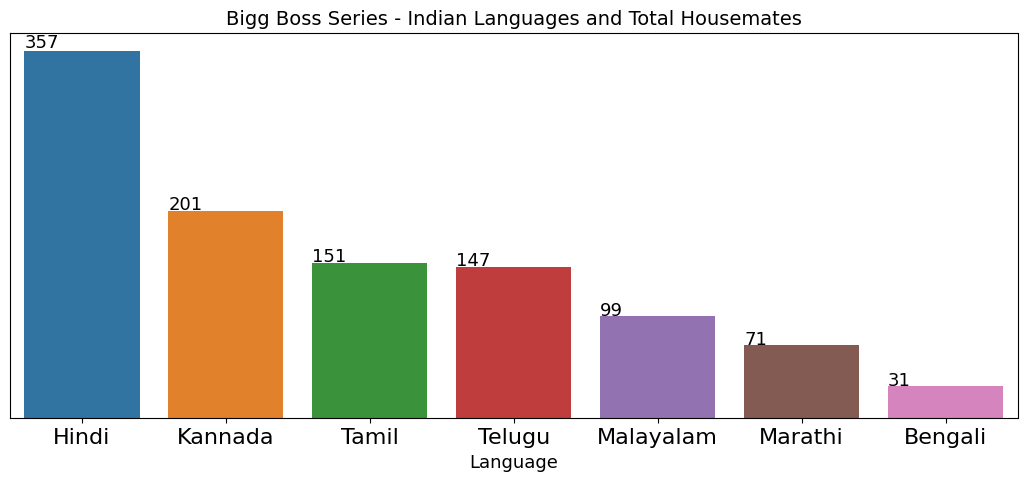

In [16]:
# Total number of Bigg Boss housemates, language wise
fig = plt.figure(figsize=(13, 5))
ax = sns.countplot(x='Language', data=bigg_boss, order=bigg_boss['Language'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Languages and Total Housemates', fontsize=14)
plt.xticks(fontsize=16)
plt.yticks([])
plt.xlabel("Language", fontsize=13)
plt.ylabel("")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=13)

## 🇮🇳 In Bigg Boss India seasons, most of the housemates entered in first day/week

Wild Card
No     899
Yes    158
Name: count, dtype: int64 

Wild Card
No     85%
Yes    15%
Name: proportion, dtype: object 



<Axes: ylabel='count'>

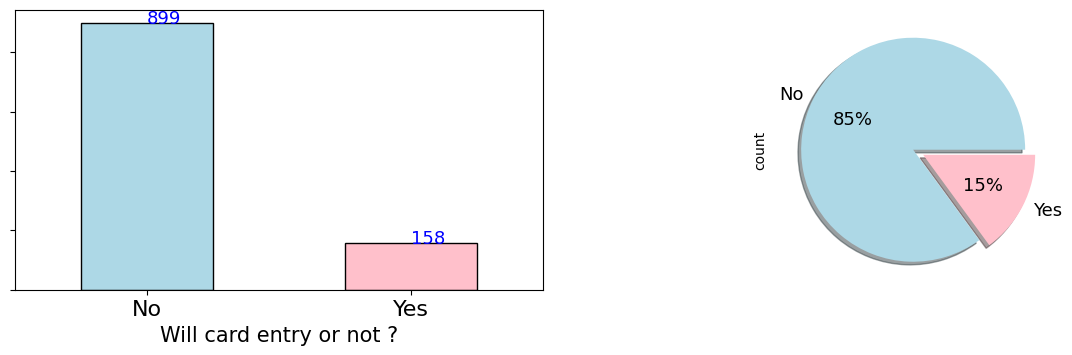

In [17]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%', regex=False), "\n")

plt.figure(figsize=(15, 8))
ax1=plt.subplot(221)
bigg_boss['Wild Card'].value_counts().plot(kind='bar', color=["lightblue","pink"], ec="k")
plt.xlabel("Will card entry or not ?", fontsize=15)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss['Wild Card'].value_counts()):
    plt.annotate(y, (x,y), fontsize=13, color="blue")

ax2=plt.subplot(222)
bigg_boss['Wild Card'].value_counts().plot(kind='pie', autopct='%.0f%%', explode=(0,0.10), colors=["lightblue","pink"], shadow=True, fontsize=13)

Age
Middle    158
Young      60
Old        15
Name: count, dtype: int64 

Age
Middle    68%
Young     26%
Old        6%
Name: proportion, dtype: object


<Axes: ylabel='count'>

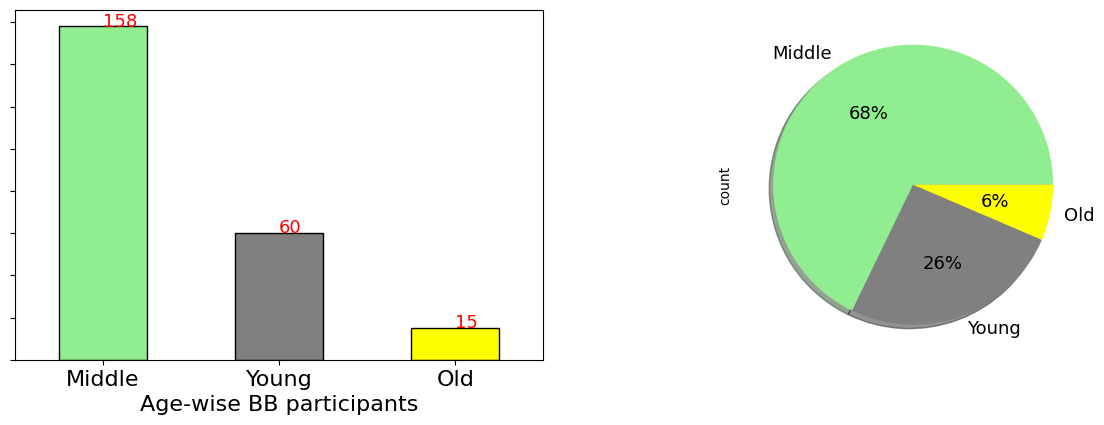

In [18]:
# Age of housemates   (Age <30 young, 30-50 middle, >50 old)
print(bigg_boss['Age'].value_counts(), '\n')

# In percentage
print(round(bigg_boss['Age'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

plt.figure(figsize=(15, 10))
ax1=plt.subplot(221)
bigg_boss['Age'].value_counts().plot(kind='bar', color=["lightgreen", "gray", "yellow"], ec="k")
plt.xlabel("Age-wise BB participants", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss['Age'].value_counts()):
    plt.annotate(y, (x,y), fontsize=13, color="Red")

ax2=plt.subplot(222)
bigg_boss['Age'].value_counts().plot(kind='pie', autopct='%.0f%%', explode = (0, 0, 0), colors=["lightgreen", "gray", "yellow"], shadow=True,fontsize=13)

In [19]:
# Common people has many professions, so clubbing them into one category
bigg_boss['Profession'] = bigg_boss['Profession'].fillna('UNKNOWN')
bigg_boss.loc[bigg_boss['Profession'].str.contains('Commoner'),'Profession'] = 'Commoner'

## 💚 Number of film actresses entered into the Bigg Boss houses, are more when compared to other professions

Profession
Actress                  206
Actor                    137
Soap Actress             116
Model                     72
Soap Actor                66
Singer                    66
Social Media Star         48
Commoner                  41
Comedian                  38
Reality Show Alumni       27
TV Anchor                 25
Radio Jockey              22
News Presenter            22
Choreographer             21
Activist                  17
Pageant Winner            15
Sports Person             11
Film Director             10
Video Jockey               9
Dancer                     8
Politician                 6
International Star         6
Entrepreneur               5
Controversial Fame         4
Swamiji                    4
Producer                   3
Numerologist               3
Journalist                 3
Wrestler                   3
Musician                   3
Art Director               2
Film director              2
Lyricist                   2
Theatre Artist             2
Fol

Text(0, 0.5, 'Count')

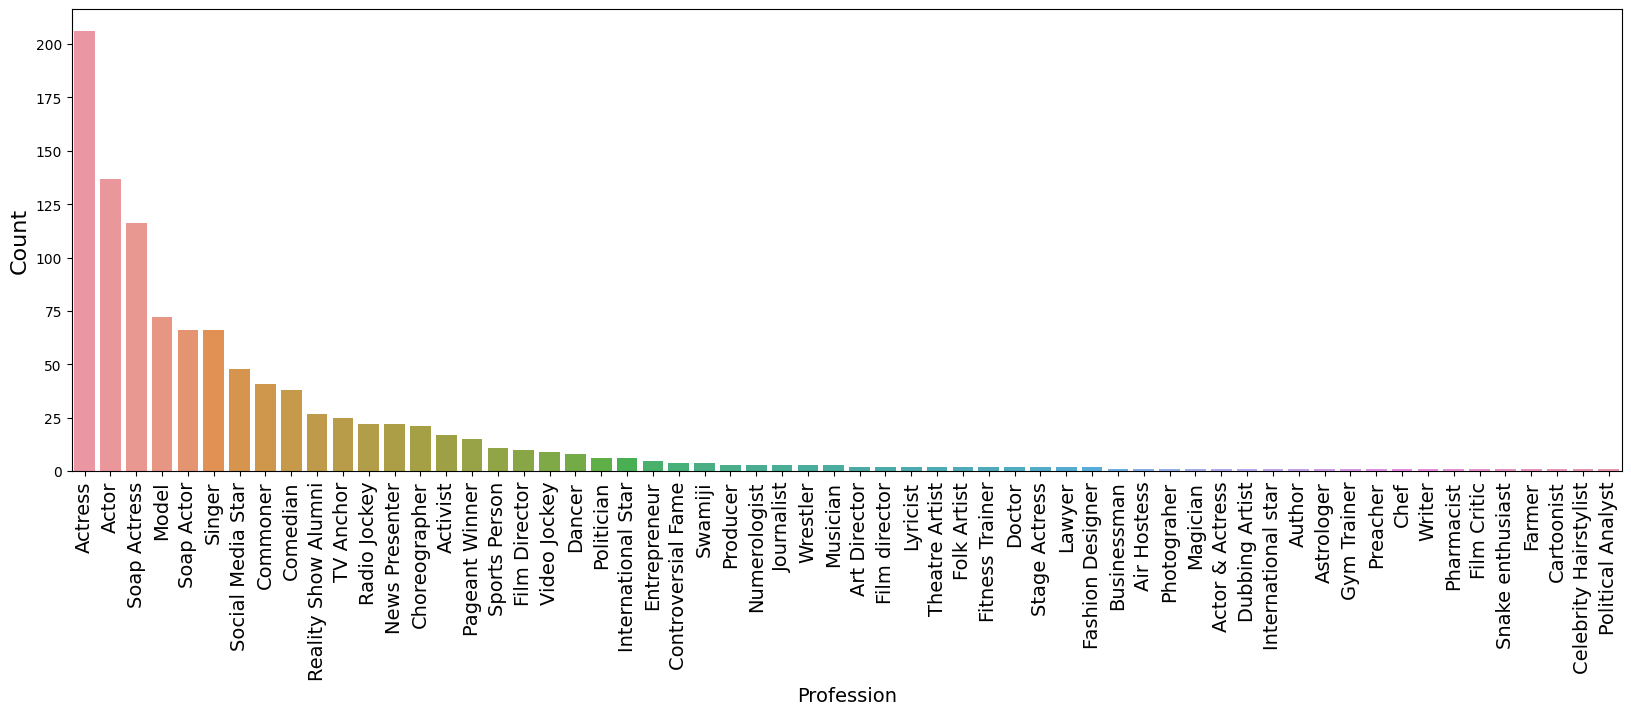

In [20]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(20, 6))
sns.countplot(x='Profession', data=bigg_boss, order=bigg_boss['Profession'].value_counts().index)
plt.xticks(fontsize=14, rotation=90)
plt.xlabel("Profession", fontsize=14)
plt.ylabel("Count", fontsize=16)

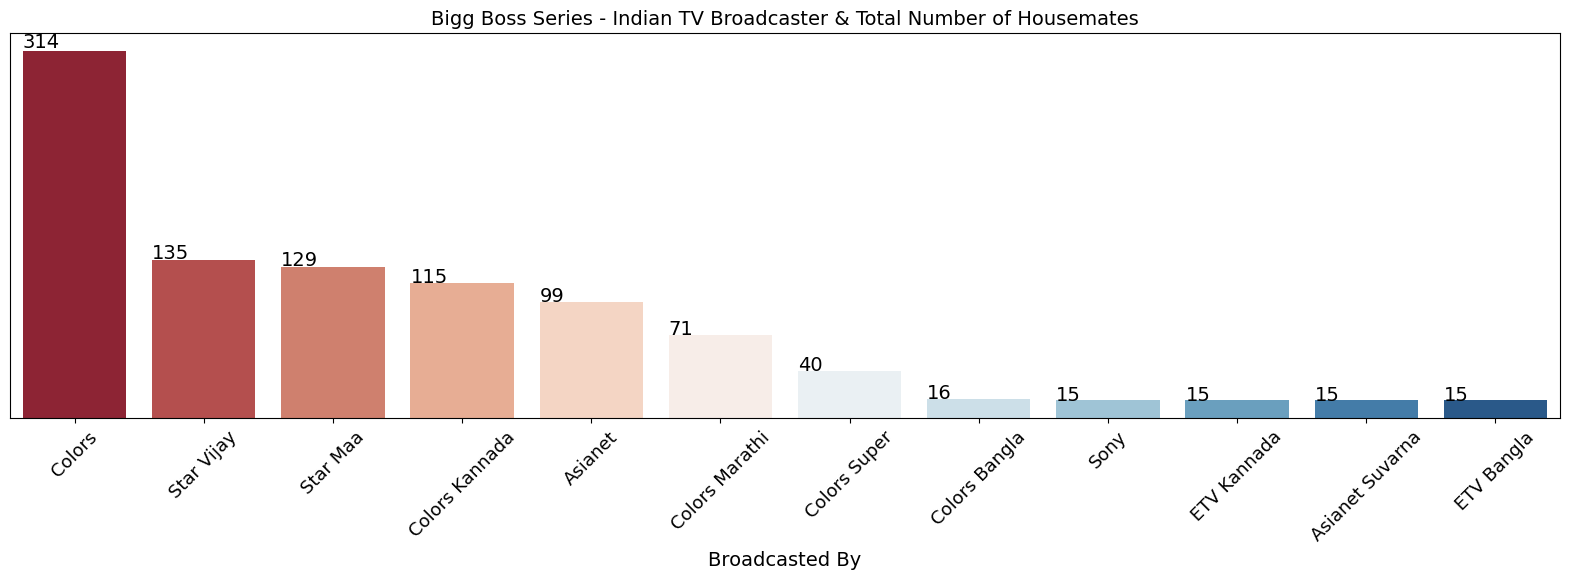

In [21]:
# TV Broadcaster
fig = plt.figure(figsize=(20, 5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu', order=bigg_boss['Broadcasted By'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian TV Broadcaster & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=13, rotation=45)
plt.yticks([])
plt.xlabel("Broadcasted By", fontsize=14)
plt.ylabel("")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

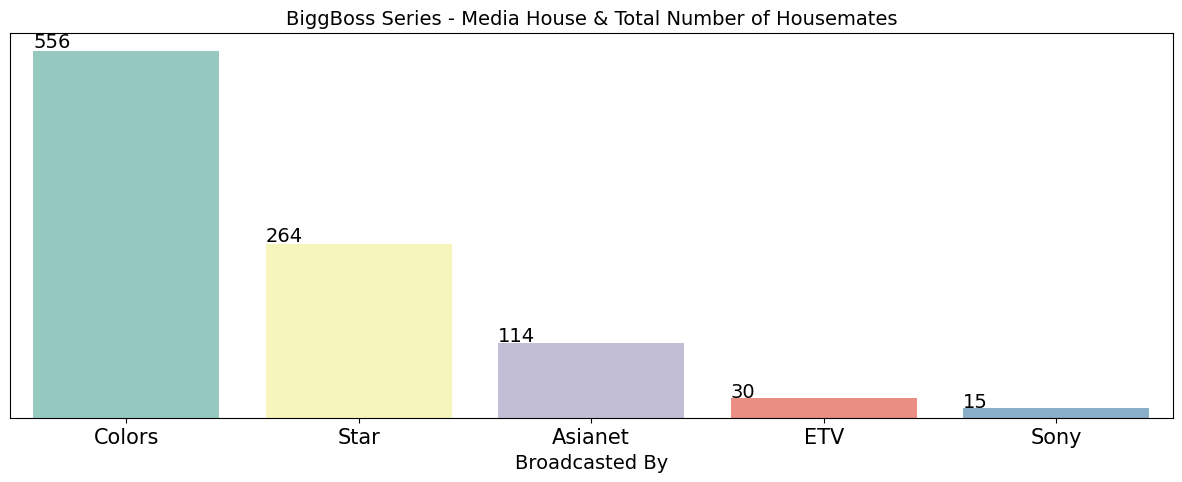

In [22]:
# Media House
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(x=bigg_boss['Broadcasted By'].str.split().str.get(0).replace('Disney+', 'Star'), data=bigg_boss, palette='Set3', order=bigg_boss['Broadcasted By'].str.split().str.get(0).replace('Disney+', 'Star').value_counts().index)
ax.set_title('BiggBoss Series - Media House & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks([])
plt.xlabel("Broadcasted By", fontsize=14)
plt.ylabel("")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

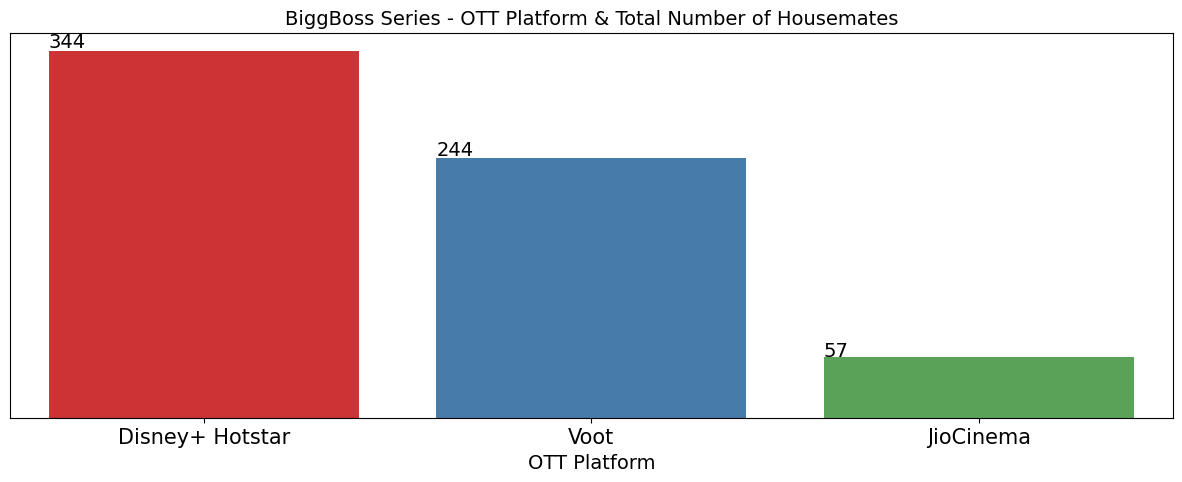

In [23]:
# OTT platforms
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(x=bigg_boss['OTT Platform'], data=bigg_boss, palette='Set1', order=bigg_boss['OTT Platform'].value_counts().index)
#ax = sns.countplot(x=bigg_boss['OTT Platform'].str.split().str.get(0).replace('Voot', 'JioCinema'), data=bigg_boss, palette='Set3', order=bigg_boss['OTT Platform'].str.split().str.get(0).replace('Voot', 'JioCinema').value_counts().index)
ax.set_title('BiggBoss Series - OTT Platform & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks([])
plt.xlabel("OTT Platform", fontsize=14)
plt.ylabel("")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

## 💢 Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next on the list

In [24]:
# Bigg Boss main hosts and number of seasons they hosted
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

Host Name
Salman Khan            15
Sudeep                 11
Kamal Haasan            8
Nagarjuna               6
Mohanlal                5
Mahesh Manjrekar        4
Amitabh Bachchan        1
Arshad Warsi            1
Farah Khan              1
Jeet                    1
Jr. NTR                 1
Karan Johar             1
Mithun Chakraborthy     1
Nani                    1
Shilpa Shetty           1
Name: Season Number, dtype: int64

In [25]:
# Temporary or Guest host who hosted the week-end episodes
bigg_boss.groupby('Guest Host Name')['Season Number'].nunique().nlargest(10)

Guest Host Name
Ramya Krishnan       2
Farah Khan           1
Karan Johar          1
Samantha             1
Sanjay Dutt          1
Siddhartha Jadhav    1
Simbu                1
Name: Season Number, dtype: int64

## 👩 In all Bigg Boss competitions, in languages and in all seasons, Female contestants are more

Gender
Female         548
Male           498
Transgender      9
Pair             2
Name: count, dtype: int64 

Gender
Female         52%
Male           47%
Transgender     1%
Pair            0%
Name: proportion, dtype: object 



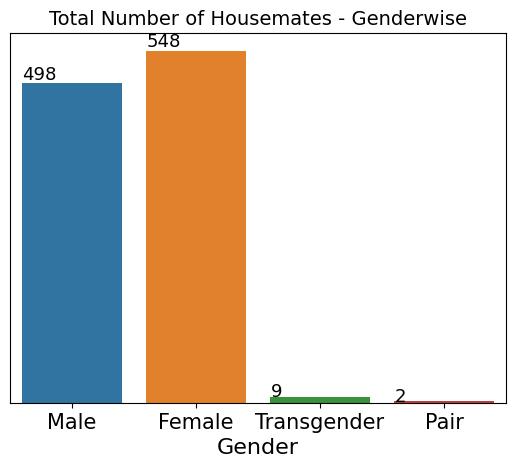

In [26]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts(), "\n")

# In percentage
print(round(bigg_boss['Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'), "\n")

ax = sns.countplot(data = bigg_boss, x = 'Gender')
ax.set_title('Total Number of Housemates - Genderwise', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks([])
plt.xlabel("Gender", fontsize=16)
plt.ylabel("")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=13)

### 9 Transgenders (LGBTQIA+) participated in all Indian languages

In [27]:
# Maximum TRP of Bigg Boss India seasons (Big Brother in India)
print("Maximum TRP", bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum TRP 20.1 

Language Season Number
  Telugu             4


In [28]:
# Smallest season of Indian Bigg Boss seasons
print("Smallest season", bigg_boss['Season Length'].min(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].min()][["Language","Season Number"]].head(1).to_string(index=False))

Smallest season 28 days 

Language Season Number
   Hindi     Halla Bol


In [29]:
# Longest season of Bigg Boss Indian seasons
print("Longest season", bigg_boss['Season Length'].max(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Longest season 141 days 

Language Season Number
   Hindi            14


## 🎆 Shark Tank India data set https://www.kaggle.com/datasets/thirumani/shark-tank-india

In [30]:
print("Maximum number of contestants in one season:", bigg_boss['Number of Housemates'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Housemates']==bigg_boss['Number of Housemates'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum number of contestants in one season: 24 

Language Season Number
   Hindi            15


In [31]:
print("Maximum number of evictions faced in one season:", bigg_boss['Number of Evictions Faced'].max(), "\n")
print("\nTop 6 contestants who faced highest/maximum number of evictions\n")
print(bigg_boss.loc[bigg_boss['Number of Evictions Faced']>=bigg_boss['Number of Evictions Faced'].max()-1][["Language","Season Number","Name","Number of Evictions Faced"]].head(10).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))

Maximum number of evictions faced in one season: 14 


Top 6 contestants who faced highest/maximum number of evictions

Language Season Number               Name  Number of Evictions Faced
   Hindi            14      Rubina Dilaik                         14
 Kannada             8 Prashanth Sambargi                         14
   Hindi            13         Arti Singh                         13
 Kannada             7      Chandan Achar                         13
  Telugu             7       Prince Yawar                         13
   Tamil             6     Mohammed Azeem                         13


In [32]:
bigg_boss['Season Length in weeks'] = round(bigg_boss['Season Length']/7,0).astype(pd.Int32Dtype())
bigg_boss['Evictions Faced Percentage'] = round(bigg_boss['Number of Evictions Faced']/bigg_boss['Season Length in weeks']*100,0).astype(pd.Int32Dtype())
print("Maximum percentage of evictions faced in one season:", bigg_boss['Evictions Faced Percentage'].max(), "%\n")
print("\nTop 5 contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
print(bigg_boss.loc[bigg_boss['Evictions Faced Percentage']>=bigg_boss['Evictions Faced Percentage'].max()-10][["Language","Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(8).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))

Maximum percentage of evictions faced in one season: 100 %


Top 5 contestants who faced maximum percentage of evictions (they were in nominations almost every week)

Language Season Number               Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
   Hindi     Halla Bol      Dimpy Ganguly                          4                       4                         100
   Hindi     Halla Bol     Sambhavna Seth                          4                       4                         100
 Kannada           OTT Jayashree Aradhaya                          6                       6                         100
   Tamil      Ultimate      Maria Juliana                         10                      10                         100
  Telugu      Non-Stop     Mitraaw Sharma                         11                      12                          92


In [33]:
print("Maximum number of re-entries:", bigg_boss['Number of Re-entries'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Re-entries']>=bigg_boss['Number of Re-entries'].max()-1][["Language","Season Number","Name","Number of Re-entries"]].head(10).sort_values("Number of Re-entries",ascending=False).to_string(index=False))

Maximum number of re-entries: 3 

Language Season Number           Name  Number of Re-entries
   Hindi            16     Tina Datta                     3
   Hindi             2 Raja Chaudhary                     2
   Hindi            10 Priyanka Jagga                     2
   Hindi            14    Vikas Gupta                     2
 Kannada            10  Prathap Drone                     2
  Telugu             1   Mumaith Khan                     2
  Telugu             2    Nutan Naidu                     2


In [34]:
print("Maximum number of times elected as captain:", bigg_boss['Number of Times Elected as Captain'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Times Elected as Captain']>=bigg_boss['Number of Times Elected as Captain'].max()-1][["Language","Season Number","Name","Number of Times Elected as Captain"]].head(8).sort_values("Number of Times Elected as Captain",ascending=False).to_string(index=False))

Maximum number of times elected as captain: 5 

 Language Season Number                  Name  Number of Times Elected as Captain
    Hindi            12           Surbhi Rana                                   5
    Hindi            16 Nimrit Kaur Ahluwalia                                   5
    Hindi             1             Rahul Roy                                   4
    Hindi             9         Prince Narula                                   4
    Hindi            16          Shiv Thakare                                   4
    Tamil             6     Manikandan Rajesh                                   4
Malayalam             2         Saju Navodaya                                   4


In [35]:
# Number of seasons in Bigg Boss house location
print(bigg_boss.groupby('House Location')['Season Number'].nunique().nlargest(10))

House Location
Lonavala     12
Mumbai       11
Bengaluru     9
Chennai       8
Hyderabad     7
Karjat        1
Name: Season Number, dtype: int64


In [36]:
# Persons walked out from the BB houses, due to health/personal reasons
print(bigg_boss.loc[bigg_boss['Walked']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['Walked']>=1]

87


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,Middle,2008-08-17,NaT,<NA>,10.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
19,Hindi,2,Jade Goody,International Star,Female,NaN,2008-08-17,NaT,<NA>,14.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,0
23,Hindi,2,Rahul Mahajan,Politician,Male,NaN,2008-08-17,NaT,<NA>,5.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,36
24,Hindi,2,Raja Chaudhary,Actor,Male,NaN,2008-08-17,2008-11-22,14,9.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,0,2,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,43
28,Hindi,2,Zulfi Syed,Model,Male,NaN,2008-08-17,2008-11-22,14,8.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,0,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,Malayalam,4,Manikandan Thonnakkal,Social Media Star,Male,NaN,NaT,NaT,4,18.0,Yes,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,8.10,Kerala,Mumbai,No,Things will be Colourful,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,0
1036,Malayalam,5,Aiswarya Suresh,Dancer,Female,NaN,2023-03-26,NaT,5,15.0,No,99,21,2023-03-26,2023-07-02,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,3,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,21
1045,Malayalam,5,Nadira Mehrin,Journalist,Transgender,NaN,2023-03-26,NaT,14,14.0,No,99,21,2023-03-26,2023-07-02,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,5,1,0,1.0,0.0,NaN,NaN,1.0,NaN,2.0,NaN,<NA>,1,0.0,14,36
1047,Malayalam,5,Rinosh George,Singer,Male,NaN,2023-03-26,NaT,13,2.0,No,99,21,2023-03-26,2023-07-02,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,6,0,0,1.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,<NA>,0,0.0,14,43


In [37]:
# Persons ejected from the BB houses, due to violation/legal issues
print(bigg_boss.loc[bigg_boss['Ejected']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['Ejected']>=1]

41


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
12,Hindi,1,Salil Ankola,Sports Person,Male,NaN,2006-11-03,NaT,1,13.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,0,0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,0
23,Hindi,2,Rahul Mahajan,Politician,Male,NaN,2008-08-17,NaT,<NA>,5.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,36
35,Hindi,3,Kamal Rashid Khan,Film Director,Male,NaN,2009-10-04,NaT,2,3.0,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,3,0,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,25
49,Hindi,4,Devinder Singh,Controversial Fame,Male,NaN,2010-10-03,NaT,1,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,1,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,7
54,Hindi,4,Samir Soni,Actor,Male,NaN,2010-10-03,NaT,13,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,0,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,43
60,Hindi,4,Dolly Bindra,Actress,Female,NaN,NaT,2011-01-08,14,16.0,Yes,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,29
68,Hindi,5,Pooja Mishra,Reality Show Alumni,Female,NaN,2011-10-02,NaT,<NA>,11.0,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,6,1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,43
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaN,NaT,2013-01-12,14,18.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,1,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,36
105,Hindi,7,Kushal Tandon,Model,Male,NaN,2013-09-15,NaT,14,9.0,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,Hell & Heaven,8,1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,53
127,Hindi,8,Puneet Issar,Actor,Male,NaN,2014-09-21,2015-01-03,15,14.0,No,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,7,1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,15,47


In [38]:
# Many contestants entered via wild card, but 30 people managed to go to Finale
print(bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), 'Finalist'].count())
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), :]

30


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
44,Hindi,3,Pravesh Rana,Model,Male,NaN,NaT,NaT,12,15.0,Yes,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,33
59,Hindi,4,Dalip Singh Rana (Khali),Wrestler,Male,NaN,NaT,2011-01-08,14,15.0,Yes,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,29
60,Hindi,4,Dolly Bindra,Actress,Female,NaN,NaT,2011-01-08,14,16.0,Yes,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,29
75,Hindi,5,Amar Upadhyay,Soap Actor,Male,NaN,NaT,2012-01-07,14,15.0,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,7,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,50
76,Hindi,5,Siddharth Bhardwaj,Reality Show Alumni,Male,NaN,NaT,2012-01-07,14,16.0,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,5,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,36
77,Hindi,5,Akashdeep Saigal,Soap Actor,Male,NaN,NaT,2012-01-07,14,17.0,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,5,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,36
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaN,NaT,2013-01-12,14,18.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,1,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,36
115,Hindi,7,Ajaz Khan,Actor,Male,NaN,NaT,2013-12-28,15,18.0,Yes,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,Hell & Heaven,7,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,15,47
133,Hindi,8,Ali Quli Mirza,Singer,Male,NaN,NaT,2015-01-03,15,16.0,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,3,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,15,40
135,Hindi,8,Dimpy Ganguly,Soap Actress,Female,Young,NaT,2015-01-03,15,18.0,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,15,33


In [39]:
# Number of Wild card entries went to Finale, as per Language
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), 'Language'].value_counts()

Language
Hindi        15
Tamil         7
Telugu        3
Marathi       3
Malayalam     2
Name: count, dtype: int64

In [40]:
# Persons who participated in more than one season (in same/different languages)
print(bigg_boss.groupby('Name')['Season Number'].nunique().nlargest(60))
bigg_boss[bigg_boss.groupby('Name')['Season Number'].transform('size')>1] [["Name", "Language", "Season Number"]].sort_values(by=['Name','Season Number'], ascending=True)

Name
Rakhi Sawant              4
Rahul Mahajan             3
Shamita Shetty            3
Abhijit Bichukale         2
Abhinay Vaddi             2
Abhirami Venkatachalam    2
Ajaz Khan                 2
Akhil Sarthak             2
Ali Quli Mirza            2
Anitha Sampath            2
Anupama Gowda             2
Ariyana Glory             2
Aroh Velankar             2
Arshi Khan                2
Arun Sagar                2
Aryavardhan Guruji        2
Ashu Reddy                2
Baba Bhaskar              2
Balaji Murugadoss         2
Bindu Madhavi             2
Deepika Das               2
Dimpy Ganguly             2
Divya Uruduga             2
Gautam Gulati             2
Hamida Khatoon            2
Karishma Tanna            2
Mahek Chahal              2
Mahesh Vitta              2
Manu Punjabi              2
Maria Juliana             2
Megha Dhade               2
Mumaith Khan              2
Nataraj                   2
Neha Bhasin               2
Neha Gowda                2
Niroop Nandhaku

,Name,Language,Season Number
298,Abhijit Bichukale,Hindi,15
874,Abhijit Bichukale,Marathi,2
776,Abhinay Vaddi,Tamil,5
796,Abhinay Vaddi,Tamil,Ultimate
741,Abhirami Venkatachalam,Tamil,3
...,...,...,...
808,Thamarai Selvi,Tamil,Ultimate
755,Vanitha Vijayakumar,Tamil,3
809,Vanitha Vijayakumar,Tamil,Ultimate
201,Vikas Gupta,Hindi,11


In [41]:
# Persons who participated in more than one language
bigg_boss.groupby('Name')['Language'].nunique().nlargest(5)

Name
Abhijit Bichukale    2
Bindu Madhavi        2
Megha Dhade          2
Rakhi Sawant         2
Shakeela             2
Name: Language, dtype: int64

In [42]:
# Housemates eliminated or walked without facing even single nomination 
print(bigg_boss.loc[(bigg_boss['Number of Evictions Faced']==0), 'Number of Evictions Faced'].count())
bigg_boss.loc[(bigg_boss['Number of Evictions Faced']==0), :]

16


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
12,Hindi,1,Salil Ankola,Sports Person,Male,NaN,2006-11-03,NaT,1,13.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,0,0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,0
19,Hindi,2,Jade Goody,International Star,Female,NaN,2008-08-17,NaT,<NA>,14.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,0
39,Hindi,3,Shamita Shetty,Actress,Female,NaN,2009-10-04,NaT,<NA>,10.0,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,0
73,Hindi,5,Sonika Kaliraman,Wrestler,Female,NaN,2011-10-02,NaT,<NA>,10.0,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,0
152,Hindi,9,Kishwer Merchant,Soap Actress,Female,NaN,2015-10-11,NaT,<NA>,3.0,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,0,2,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,0
299,Hindi,15,Raqesh Bapat,Actor,Male,NaN,NaT,NaT,6,20.0,Yes,120,24,2021-10-02,2022-01-30,Salman Khan,NaN,0.0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Sankat in Jungle,Jungle,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,17,0
333,Hindi,OTT S2,Puneet Kumar,Social Media Star,Male,NaN,2023-06-17,NaT,1,10.0,No,57,15,2023-06-17,2023-08-14,Salman Khan,NaN,0.0,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,NaN,Recycled,0,0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,8,0
389,Kannada,3,Huccha Venkat,Actor,Male,NaN,2015-10-25,NaT,<NA>,NaN,No,98,18,2015-10-25,2016-01-31,Sudeep,NaN,0.0,Colors Kannada,NaN,NaN,Karnataka,Bengaluru,No,There is no place for drama here,NaN,0,0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,0
501,Kannada,8,Vyjayanthi Adiga,Actress,Female,NaN,NaT,NaT,6,19.0,Yes,117,20,2021-02-28,2021-08-08,Sudeep,NaN,0.0,Colors Kannada,Voot,NaN,Karnataka,Bengaluru,No,NaN,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,17,0
786,Tamil,5,Namitha Marimuthu,Model,Transgender,NaN,2021-10-03,NaT,1,5.0,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,Disney+ Hotstar,17.90,Tamil Nadu,Chennai,No,Expect the unexpected,Nature,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,0


In [43]:
# Only two pairs entered into BB houses
bigg_boss.loc[(bigg_boss['Gender']=="Pair"), :]

# Many other couples entered into Bigg Boss, but as individual contestants

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
997,Malayalam,2,Abhirami Suresh & Amrutha Suresh,Singer,Pair,NaN,NaT,NaT,<NA>,22.0,Yes,75,22,2020-01-05,2020-03-20,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,11.03,Kerala,Chennai,No,"it's no longer just big games, now the games w...",NaN,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,11,27
1013,Malayalam,3,Firoz Khan & Sajna Firoz,Actor & Actress,Pair,NaN,NaT,NaT,9,16.0,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,12.40,Kerala,Chennai,No,The Show Must Go On,NaN,7,0,0,0.0,1.0,NaN,NaN,NaN,3.0,NaN,NaN,<NA>,0,0.0,14,50


In [44]:
# Persons stayed in the BB house secret rooms
print(bigg_boss.loc[bigg_boss['In Secret-Room']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['In Secret-Room']>=1]

38


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
24,Hindi,2,Raja Chaudhary,Actor,Male,NaN,2008-08-17,2008-11-22,14,9.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,0,2,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,43
55,Hindi,4,Sara Khan,Soap Actress,Female,NaN,2010-10-03,NaT,4,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,0,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,29
79,Hindi,6,Aashka Goradia,Soap Actress,Female,NaN,2012-10-07,NaT,12,6.0,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,1,1,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,29
93,Hindi,6,Vrajesh Hirjee,Actor,Male,NaN,2012-10-07,NaT,9,3.0,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,1,1,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,29
95,Hindi,6,Vishal Karwal,Soap Actor,Male,NaN,NaT,NaT,11,17.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,1,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,36
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaN,NaT,2013-01-12,14,18.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,1,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,36
97,Hindi,6,Santosh Shukla,Actor,Male,NaN,NaT,NaT,11,19.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,3,0,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,21
153,Hindi,9,Mandana Karimi,International Star,Female,NaN,2015-10-11,2016-01-23,15,9.0,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,12,0,0,0.0,0.0,1.0,NaN,NaN,NaN,1.0,NaN,<NA>,1,0.0,15,80
174,Hindi,10,Manu Punjabi,Reality Show Alumni,Male,NaN,2016-10-16,NaT,<NA>,10.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0.0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,4,0,1,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,15,27
178,Hindi,10,Priyanka Jagga,Commoner,Female,NaN,2016-10-16,NaT,8,12.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0.0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,2,0,2,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,13


In [45]:
# Housemates were ejected from BB house, but returned from secret room
print(bigg_boss.loc[(bigg_boss['In Secret-Room']>=1) & (bigg_boss['Ejected']>=1)]['Name'].count())
bigg_boss.loc[(bigg_boss['In Secret-Room']>=1) & (bigg_boss['Ejected']>=1)]

5


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaN,NaT,2013-01-12,14,18.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,1,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,36
178,Hindi,10,Priyanka Jagga,Commoner,Female,NaN,2016-10-16,NaT,8,12.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0.0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,2,0,2,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,13
181,Hindi,10,Swami Om,Swamiji,Male,NaN,2016-10-16,NaT,<NA>,1.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0.0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,2,0,1,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,<NA>,0,0.0,15,13
567,Telugu,1,Mumaith Khan,Actress,Female,Middle,2017-07-16,2017-09-03,7,3.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,NaN,15.00,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,3,1,2,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,10,30
1028,Malayalam,4,Robin Radhakrishnan,Doctor,Male,NaN,2022-03-27,NaT,10,4.0,No,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,8.10,Kerala,Mumbai,No,Things will be Colourful,NaN,7,0,0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,7,0,0.0,14,50


In [46]:
# Swami Om was the only participant, who walked out and ejected from house and went to secret room
bigg_boss.loc[(bigg_boss['In Secret-Room']>=1) & (bigg_boss['Ejected']>=1) & (bigg_boss['Walked']>=1)]

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
181,Hindi,10,Swami Om,Swamiji,Male,NaN,2016-10-16,NaT,<NA>,1.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0.0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,2,0,1,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,<NA>,0,0.0,15,13


In [47]:
# Housemates who won Ticket to Finale
print(bigg_boss.loc[bigg_boss['Won Ticket to Finale']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['Won Ticket to Finale']>=1]

25


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
175,Hindi,10,Manveer Gurjar,Commoner,Male,Young,2016-10-16,NaT,<NA>,3.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,5000000.0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,7,3,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,8,1,1.0,15,47
193,Hindi,11,Luv Tyagi,Commoner,Male,NaN,2017-10-01,NaT,14,2.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0.0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,7,1,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,<NA>,0,0.0,15,47
196,Hindi,11,Puneesh Sharma,Reality Show Alumni,Male,NaN,2017-10-01,NaT,15,15.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0.0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,5,1,0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,NaN,6,1,0.0,15,33
221,Hindi,12,Surbhi Rana,Commoner,Female,NaN,NaT,2018-12-30,15,18.0,Yes,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,0.0,Colors,NaN,4.99,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Strange pairing,Beach House,4,5,1,0.0,0.0,NaN,NaN,1.0,NaN,NaN,Success,<NA>,0,0.0,15,27
253,Hindi,14,Rubina Dilaik,Soap Actress,Female,Middle,2020-10-03,NaT,<NA>,4.0,No,141,22,2020-10-03,2021-02-21,Salman Khan,NaN,3600000.0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Ab Scene Paltega,Futuristic,14,1,0,0.0,0.0,NaN,1.0,1.0,NaN,NaN,NaN,9,1,1.0,20,70
311,Hindi,16,Nimrit Kaur Ahluwalia,Soap Actress,Female,NaN,2022-10-01,NaT,19,1.0,No,134,17,2022-10-01,2023-02-12,Salman Khan,Karan Johar,0.0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,"Game Badlega, Kyunki Bigg Boss Khud Khelega",Circus,5,5,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,<NA>,0,0.0,19,26
548,Kannada,10,Sangeetha Sringeri,Soap Actress,Female,NaN,2023-10-08,NaT,<NA>,12.0,No,106,21,2023-10-08,2024-01-28,Sudeep,NaN,NaN,Colors Kannada,JioCinema,NaN,Karnataka,Bengaluru,No,NaN,Happy Bigg Boss,8,1,1,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,<NA>,1,NaN,15,53
610,Telugu,4,Akhil Sarthak,Soap Actor,Male,Middle,2020-09-06,2020-12-20,15,15.0,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha,0.0,Star Maa,Disney+ Hotstar,20.10,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,7,1,0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,9,1,0.0,15,47
643,Telugu,5,Sunny,Video Jockey,Male,Middle,2021-09-05,NaT,<NA>,2.0,No,105,19,2021-09-05,2021-12-19,Nagarjuna,NaN,5000000.0,Star Maa,Disney+ Hotstar,18.20,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,9,1,0,0.0,0.0,NaN,NaN,1.0,NaN,2.0,NaN,10,1,1.0,15,60
683,Telugu,6,Shrihan Shaik,Social Media Star,Male,Middle,2022-09-04,2022-12-18,15,3.0,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,4000000.0,Star Maa,Disney+ Hotstar,8.40,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,9,1,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,9,1,0.0,15,60


In [48]:
# Housemates who won Eviction Free Pass
print(bigg_boss.loc[bigg_boss['Won Eviction Free Pass']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['Won Eviction Free Pass']>=1]

25


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
21,Hindi,2,Monica Bedi,Actress,Female,NaN,2008-08-17,NaT,13,1.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,3,0,1,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,21
24,Hindi,2,Raja Chaudhary,Actor,Male,NaN,2008-08-17,2008-11-22,14,9.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,0,2,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,43
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,Middle,2012-10-07,NaT,<NA>,5.0,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,5000000.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
134,Hindi,8,Renee Dhyani,Reality Show Alumni,Female,NaN,NaT,NaT,10,17.0,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,7
135,Hindi,8,Dimpy Ganguly,Soap Actress,Female,Young,NaT,2015-01-03,15,18.0,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,15,33
143,Hindi,Halla Bol,Pritam Singh,Radio Jockey,Male,NaN,2015-01-04,NaT,4,3.0,No,28,10,2015-01-04,2015-01-31,Farah Khan,NaN,0.0,Colors,NaN,2.82,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,3,1,0,1.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,4,75
199,Hindi,11,Shilpa Shinde,Soap Actress,Female,Middle,2017-10-01,NaT,<NA>,17.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,5000000.0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,10,0,0,0.0,0.0,NaN,1.0,NaN,1.0,NaN,NaN,8,1,1.0,15,67
212,Hindi,12,Romil Chaudhary,Commoner,Male,NaN,2018-09-16,2018-12-30,15,5.0,No,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,0.0,Colors,NaN,4.99,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Strange pairing,Beach House,6,3,1,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,5,1,0.0,15,40
234,Hindi,13,Shehnaaz Gill,Singer,Female,NaN,2019-09-29,NaT,20,9.0,No,140,21,2019-09-29,2020-02-15,Salman Khan,NaN,0.0,Colors,NaN,9.06,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Bigg Boss Tedha,Bigg Boss Museum,11,1,0,0.0,0.0,NaN,1.0,NaN,NaN,1.0,NaN,8,1,0.0,20,55
249,Hindi,14,Nikki Tamboli,Actress,Female,NaN,2020-10-03,NaT,20,2.0,No,141,22,2020-10-03,2021-02-21,Salman Khan,NaN,0.0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Ab Scene Paltega,Futuristic,11,0,1,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,7,1,0.0,20,55


In [49]:
# Housemates who received Best Performer
print(bigg_boss.loc[bigg_boss['Number of Times Best Performer']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['Number of Times Best Performer']>=1]

29


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
185,Hindi,11,Akash Anil Dadlani,Singer,Male,NaN,2017-10-01,NaT,15,10.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0.0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,5,0,0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,<NA>,0,0.0,15,33
186,Hindi,11,Arshi Khan,Actress,Female,NaN,2017-10-01,NaT,12,13.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0.0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,2,1,0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,<NA>,0,0.0,15,13
190,Hindi,11,Hiten Tejwani,Soap Actor,Male,NaN,2017-10-01,NaT,11,1.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0.0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,3,1,0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,<NA>,0,0.0,15,20
199,Hindi,11,Shilpa Shinde,Soap Actress,Female,Middle,2017-10-01,NaT,<NA>,17.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,5000000.0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,10,0,0,0.0,0.0,NaN,1.0,NaN,1.0,NaN,NaN,8,1,1.0,15,67
201,Hindi,11,Vikas Gupta,Producer,Male,NaN,2017-10-01,NaT,15,16.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0.0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,6,2,0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,Success,6,1,0.0,15,40
543,Kannada,10,Michel Ajay,Model,Male,NaN,2023-10-08,NaT,13,18.0,No,106,21,2023-10-08,2024-01-28,Sudeep,NaN,0.0,Colors Kannada,JioCinema,NaN,Karnataka,Bengaluru,No,NaN,Happy Bigg Boss,11,2,<NA>,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,<NA>,0,0.0,15,73
545,Kannada,10,Neethu Vanajakshi,Pageant Winner,Transgender,NaN,2023-10-08,NaT,7,9.0,No,106,21,2023-10-08,2024-01-28,Sudeep,NaN,0.0,Colors Kannada,JioCinema,NaN,Karnataka,Bengaluru,No,NaN,Happy Bigg Boss,5,2,<NA>,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,<NA>,0,0.0,15,33
546,Kannada,10,Prathap Drone,Social Media Star,Male,Young,2023-10-08,NaT,<NA>,6.0,No,106,21,2023-10-08,2024-01-28,Sudeep,NaN,NaN,Colors Kannada,JioCinema,NaN,Karnataka,Bengaluru,No,NaN,Happy Bigg Boss,7,<NA>,2,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,<NA>,<NA>,NaN,15,47
547,Kannada,10,Rakshak Bullet,Social Media Star,Male,Young,2023-10-08,NaT,4,11.0,No,106,21,2023-10-08,2024-01-28,Sudeep,NaN,0.0,Colors Kannada,JioCinema,NaN,Karnataka,Bengaluru,No,NaN,Happy Bigg Boss,1,1,<NA>,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,<NA>,0,0.0,15,7
549,Kannada,10,Santosh Kumar Thukali,Comedian,Male,NaN,2023-10-08,NaT,<NA>,7.0,No,106,21,2023-10-08,2024-01-28,Sudeep,NaN,NaN,Colors Kannada,JioCinema,NaN,Karnataka,Bengaluru,No,NaN,Happy Bigg Boss,7,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,<NA>,<NA>,NaN,15,47


In [50]:
# Housemates who received Worst Performer
print(bigg_boss.loc[bigg_boss['Number of Times Worst Performer']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['Number of Times Worst Performer']>=1]

53


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
153,Hindi,9,Mandana Karimi,International Star,Female,NaN,2015-10-11,2016-01-23,15,9.0,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,12,0,0,0.0,0.0,1.0,NaN,NaN,NaN,1.0,NaN,<NA>,1,0.0,15,80
155,Hindi,9,Rimi Sen,Actress,Female,NaN,2015-10-11,NaT,7,6.0,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,8,0,0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,<NA>,0,0.0,15,53
161,Hindi,9,Rishabh Sinha,Reality Show Alumni,Male,NaN,NaT,2016-01-23,15,15.0,Yes,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,9,1,0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,<NA>,1,0.0,15,60
177,Hindi,10,Nitibha Kaul,Commoner,Female,NaN,2016-10-16,NaT,13,4.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0.0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,7,0,0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,<NA>,0,0.0,15,47
181,Hindi,10,Swami Om,Swamiji,Male,NaN,2016-10-16,NaT,<NA>,1.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0.0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,2,0,1,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,<NA>,0,0.0,15,13
186,Hindi,11,Arshi Khan,Actress,Female,NaN,2017-10-01,NaT,12,13.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0.0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,2,1,0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,<NA>,0,0.0,15,13
187,Hindi,11,Bandgi Kalra,Commoner,Female,NaN,2017-10-01,2017-12-03,9,12.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0.0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,2,1,0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,<NA>,0,0.0,15,13
196,Hindi,11,Puneesh Sharma,Reality Show Alumni,Male,NaN,2017-10-01,NaT,15,15.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0.0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,5,1,0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,NaN,6,1,0.0,15,33
234,Hindi,13,Shehnaaz Gill,Singer,Female,NaN,2019-09-29,NaT,20,9.0,No,140,21,2019-09-29,2020-02-15,Salman Khan,NaN,0.0,Colors,NaN,9.06,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Bigg Boss Tedha,Bigg Boss Museum,11,1,0,0.0,0.0,NaN,1.0,NaN,NaN,1.0,NaN,8,1,0.0,20,55
236,Hindi,13,Sidharth Shukla,Soap Actor,Male,Middle,2019-09-29,NaT,<NA>,1.0,No,140,21,2019-09-29,2020-02-15,Salman Khan,NaN,5000000.0,Colors,NaN,9.06,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Bigg Boss Tedha,Bigg Boss Museum,12,2,1,1.0,0.0,1.0,NaN,NaN,NaN,1.0,NaN,10,1,1.0,20,60


In [51]:
# Housemates who performed Secret Task successfully
print(bigg_boss.loc[bigg_boss['Secret Task']=='Success']['Name'].count())
bigg_boss.loc[bigg_boss['Secret Task']=='Success']

# Data Incomplete

7


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
201,Hindi,11,Vikas Gupta,Producer,Male,NaN,2017-10-01,NaT,15,16.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0.0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,6,2,0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,Success,6,1,0.0,15,40
205,Hindi,12,Deepak Thakur,Singer,Male,NaN,2018-09-16,2018-12-30,15,13.0,No,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,2000000.0,Colors,NaN,4.99,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Strange pairing,Beach House,7,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Success,6,1,0.0,15,47
216,Hindi,12,Shanthakumaran Sreesanth,Sports Person,Male,NaN,2018-09-16,2018-12-30,15,17.0,No,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,0.0,Colors,NaN,4.99,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Strange pairing,Beach House,7,1,1,0.0,0.0,1.0,NaN,NaN,NaN,NaN,Success,7,1,0.0,15,47
221,Hindi,12,Surbhi Rana,Commoner,Female,NaN,NaT,2018-12-30,15,18.0,Yes,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,0.0,Colors,NaN,4.99,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Strange pairing,Beach House,4,5,1,0.0,0.0,NaN,NaN,1.0,NaN,NaN,Success,<NA>,0,0.0,15,27
231,Hindi,13,Paras Chhabra,Soap Actor,Male,NaN,2019-09-29,NaT,20,3.0,No,140,21,2019-09-29,2020-02-15,Salman Khan,NaN,0.0,Colors,NaN,9.06,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Bigg Boss Tedha,Bigg Boss Museum,12,0,1,1.0,0.0,1.0,NaN,NaN,NaN,NaN,Success,6,1,0.0,20,60
580,Telugu,2,Geetha Madhuri,Singer,Female,Middle,2018-06-10,2018-09-30,16,1.0,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0.0,Star Maa,NaN,15.00,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,7,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Success,8,1,0.0,16,44
658,Telugu,Non-Stop,Nataraj,Choreographer,Male,Middle,2022-02-26,NaT,11,5.0,No,84,18,2022-02-26,2022-05-21,Nagarjuna,NaN,0.0,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",Hyderabad,Yes,NaN,NaN,7,1,0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,Success,<NA>,0,0.0,12,58


In [52]:
# Housemates who failed to complete Secret Task
print(bigg_boss.loc[bigg_boss['Secret Task']=='Fail']['Name'].count())
bigg_boss.loc[bigg_boss['Secret Task']=='Fail']

# Data Incomplete

4


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
173,Hindi,10,Lopamudra Raut,Model,Female,NaN,2016-10-16,2017-01-28,15,2.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0.0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,6,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Fail,6,1,0.0,15,40
670,Telugu,6,Chalaki Chanti,Comedian,Male,Middle,2022-09-04,2022-10-09,5,5.0,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,0.0,Star Maa,Disney+ Hotstar,8.40,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Fail,<NA>,0,0.0,15,20
692,Telugu,7,Priyanka Jain,Soap Actress,Female,Young,2023-09-03,2023-12-17,15,1.0,No,105,19,2023-09-03,2023-12-17,Nagarjuna,NaN,0.0,Star Maa,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",Hyderabad,No,Ulta-Pulta,NaN,9,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fail,7,1,0.0,15,60
697,Telugu,7,Sivaji,Actor,Male,Old,2023-09-03,2023-12-17,15,2.0,No,105,19,2023-09-03,2023-12-17,Nagarjuna,NaN,0.0,Star Maa,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",Hyderabad,No,Ulta-Pulta,NaN,8,1,<NA>,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Fail,9,1,0.0,15,53


## 🎉 About Winners only

In [53]:
print("Total Bigg Boss season winners", bigg_boss['Winner'].sum().astype(int), "(out of", bigg_boss['Finalist'].sum(), "finalists)")
# For Bigg Boss Hindi season 8 & Malayalam season 2 winners were not declared

Total Bigg Boss season winners 54 (out of 280 finalists)


In [54]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
8,Hindi,1,Rahul Roy,Actor,Male,Middle,2006-11-03,NaT,<NA>,1.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,4,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,12,8
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,Middle,2008-08-17,NaT,<NA>,10.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
42,Hindi,3,Vindu Dara Singh,Actor,Male,Middle,2009-10-04,NaT,<NA>,7.0,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,10000000.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,7,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,12,58
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,Middle,2010-10-03,NaT,<NA>,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,10000000.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
62,Hindi,5,Juhi Parmar,Soap Actress,Female,Middle,2011-10-02,NaT,<NA>,14.0,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,10000000.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,4,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,29
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,Middle,2012-10-07,NaT,<NA>,5.0,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,5000000.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
102,Hindi,7,Gauhar Khan,Actress,Female,Middle,2013-09-15,NaT,<NA>,4.0,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,5000000.0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,Hell & Heaven,7,2,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,15,47
140,Hindi,Halla Bol,Gautam Gulati,Soap Actor,Male,Middle,2015-01-04,NaT,<NA>,2.0,No,28,10,2015-01-04,2015-01-31,Farah Khan,NaN,5000000.0,Colors,NaN,2.82,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,4,50
154,Hindi,9,Prince Narula,Reality Show Alumni,Male,Young,2015-10-11,NaT,<NA>,12.0,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,5000000.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,4,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,15,40
175,Hindi,10,Manveer Gurjar,Commoner,Male,Young,2016-10-16,NaT,<NA>,3.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,5000000.0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,7,3,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,8,1,1.0,15,47


In [55]:
# Sum of prize money won by all BB Season winners/participants, in India
print(format_currency(bigg_boss['Prize Money (INR)'].sum(), 'INR', locale='en_IN').replace(".00", ""))

# 27 crores and 78 lakh rupees

₹27,78,55,000


In [56]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Profession'].value_counts()

Profession
Actor                  10
Soap Actress            8
Actress                 6
Soap Actor              6
Singer                  6
Reality Show Alumni     3
Commoner                2
Social Media Star       2
TV Anchor               2
Film Director           2
Radio Jockey            2
Video Jockey            2
Comedian                1
Model                   1
Pageant Winner          1
Name: count, dtype: int64

Gender
Male      39
Female    15
Name: count, dtype: int64 

Gender
Male      72%
Female    28%
Name: proportion, dtype: object


<Axes: ylabel='count'>

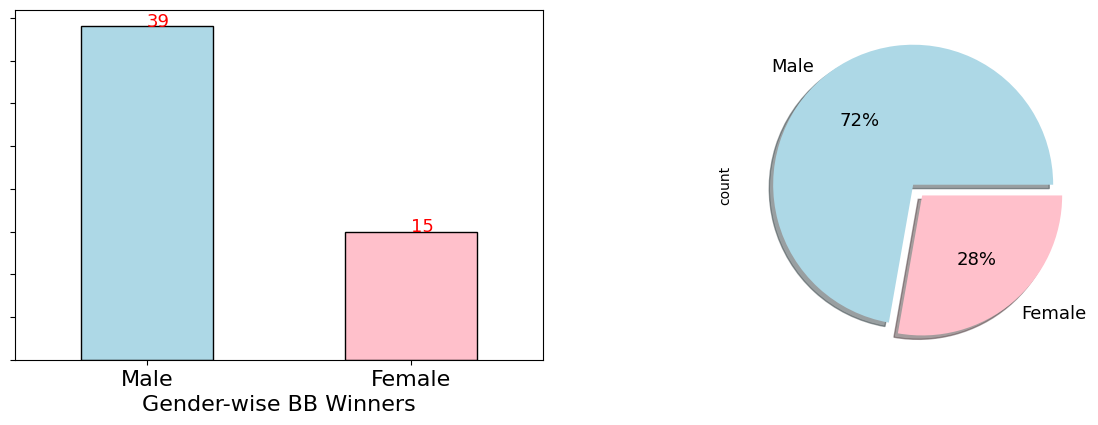

In [57]:
# Gender of Season title Winners
print(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(), '\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

plt.figure(figsize=(15, 10))
ax1=plt.subplot(221)
bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts().plot(kind='bar', color=["lightblue","pink"], ec="k")
plt.xlabel("Gender-wise BB Winners", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts()):
    plt.annotate(y, (x,y), fontsize=13, color="Red")

ax2=plt.subplot(222)
bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts().plot(kind='pie', autopct='%.0f%%', explode = (0, 0.10), colors=["lightblue","pink"], shadow=True,fontsize=13)

Age
Middle    34
Young     19
Old        1
Name: count, dtype: int64 

Age
Middle    63%
Young     35%
Old        2%
Name: proportion, dtype: object


<Axes: ylabel='count'>

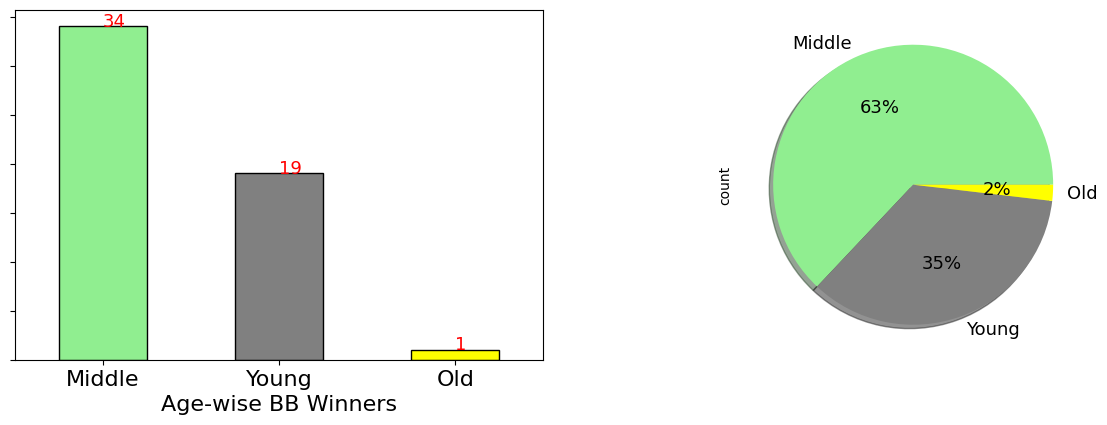

In [58]:
# Age of Season title Winners   (Age <30 young, 30-50 middle, >50 old)
print(bigg_boss.loc[bigg_boss.Winner==1, 'Age'].value_counts(), '\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1, 'Age'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

plt.figure(figsize=(15, 10))
ax1=plt.subplot(221)
bigg_boss.loc[bigg_boss.Winner==1, 'Age'].value_counts().plot(kind='bar', color=["lightgreen", "gray", "yellow"], ec="k")
plt.xlabel("Age-wise BB Winners", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss.loc[bigg_boss.Winner==1, 'Age'].value_counts()):
    plt.annotate(y, (x,y), fontsize=13, color="Red")

ax2=plt.subplot(222)
bigg_boss.loc[bigg_boss.Winner==1, 'Age'].value_counts().plot(kind='pie', autopct='%.0f%%', explode = (0, 0, 0), colors=["lightgreen", "gray", "yellow"], shadow=True,fontsize=13)

## ➡️ No wild card entry housemate won the Bigg Boss competition, until August 2023.
## but two wild-card winners after that

In [59]:
# Entry type (wildcard or not) of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Wild Card'].value_counts()

Wild Card
No     52
Yes     2
Name: count, dtype: int64

In [60]:
bigg_boss.loc[bigg_boss.Winner==1, 'Season Length'].value_counts().sort_index()

# Length of the season (in days) - Number of Winners

Season Length
28      1
42      2
57      1
70      2
84      2
86      1
90      1
95      1
97      2
98     14
99      1
102     1
105    15
106     2
112     3
117     1
120     1
134     1
140     1
141     1
Name: count, dtype: int64

In [61]:
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Housemates'].value_counts().sort_index()

# Number of Housemates in house - Number of Winners

Number of Housemates
10     1
13     1
15     7
16     5
17     6
18    11
19     7
20     9
21     4
22     1
23     1
24     1
Name: count, dtype: int64

In [62]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Evictions Faced'].value_counts().sort_index()

# Number of eliminations faced - Number of Winners

Number of Evictions Faced
1     1
2     3
4     5
5     7
6     7
7     8
8     5
9     8
10    3
11    1
12    4
13    1
14    1
Name: count, dtype: Int64

In [63]:
# 4 re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Re-entries'].value_counts()

Number of Re-entries
0    48
1     4
Name: count, dtype: Int64

In [64]:
# Bigg Boss title winners number of times elected as captain
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Times Elected as Captain'].value_counts().sort_index()

# Number of times elected as Captain - Number of winners

Number of Times Elected as Captain
0    13
1    17
2    17
3     2
4     2
Name: count, dtype: Int64

In [65]:
bigg_boss.loc[bigg_boss.Winner==1, 'Contestant Number'].value_counts().sort_index()

# Contestant Number in the season - Number of winners

Contestant Number
1.0     3
2.0     5
3.0     5
4.0     6
5.0     2
6.0     1
7.0     5
9.0     1
10.0    6
11.0    1
12.0    3
13.0    2
14.0    3
16.0    2
17.0    2
21.0    2
Name: count, dtype: int64

In [66]:
# Winners who Won Ticket to Finale
bigg_boss.loc[bigg_boss.Winner==1, 'Won Ticket to Finale'].value_counts()

# Won Ticket to Finale - Number of winners

Won Ticket to Finale
1.0    6
Name: count, dtype: int64

In [67]:
# Winners who Won Eviction Free Pass
bigg_boss.loc[bigg_boss.Winner==1, 'Won Eviction Free Pass'].value_counts()

# Won Eviction Free Pass - Number of winners

Won Eviction Free Pass
1.0    3
2.0    1
Name: count, dtype: int64

In [68]:
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Times Best Performer'].value_counts()

# Number of Times Best Performer - Number of winners

Number of Times Best Performer
1.0    1
5.0    1
Name: count, dtype: int64

In [69]:
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Times Worst Performer'].value_counts()

# Number of Times Worst Performer - Number of winners

Number of Times Worst Performer
1.0    4
2.0    1
Name: count, dtype: int64

## 🔵 BB Hindi Seasons

In [70]:
lang='Hindi'

# All Bigg Boss Hindi Participants
bigg_boss.loc[(bigg_boss['Language']==lang)]

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
0,Hindi,1,Amit Sadh,Soap Actor,Male,NaN,2006-11-03,NaT,10,5.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,17
1,Hindi,1,Anupama Verma,Model,Female,NaN,2006-11-03,NaT,5,8.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,NaN,2006-11-03,NaT,4,9.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8
3,Hindi,1,Bobby Darling,Activist,Transgender,NaN,2006-11-03,NaT,1,12.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8
4,Hindi,1,Carol Gracias,Model,Female,NaN,2006-11-03,2007-01-26,12,2.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,Hindi,17,Vikki Jain,Businessman,Male,Middle,2023-10-15,NaT,<NA>,10.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,NaN,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,5,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,<NA>,NaN,15,33
353,Hindi,17,Manasvi Mamgai,Pageant Winner,Female,Young,NaT,NaT,3,18.0,Yes,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,0.0,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,1,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,7
354,Hindi,17,Samarth Jurel,Soap Actor,Male,Young,NaT,NaT,13,19.0,Yes,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,0.0,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,4,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,27
355,Hindi,17,Park Min-jun Aoora,Singer,Male,Middle,NaT,NaT,12,20.0,Yes,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,0.0,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,1,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,7


In [71]:
# BiggBoss Hindi Winners
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner']==1), :]

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
8,Hindi,1,Rahul Roy,Actor,Male,Middle,2006-11-03,NaT,<NA>,1.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,4,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,12,8
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,Middle,2008-08-17,NaT,<NA>,10.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
42,Hindi,3,Vindu Dara Singh,Actor,Male,Middle,2009-10-04,NaT,<NA>,7.0,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,10000000.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,7,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,12,58
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,Middle,2010-10-03,NaT,<NA>,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,10000000.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
62,Hindi,5,Juhi Parmar,Soap Actress,Female,Middle,2011-10-02,NaT,<NA>,14.0,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,10000000.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,4,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,29
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,Middle,2012-10-07,NaT,<NA>,5.0,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,5000000.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
102,Hindi,7,Gauhar Khan,Actress,Female,Middle,2013-09-15,NaT,<NA>,4.0,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,5000000.0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,Hell & Heaven,7,2,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,15,47
140,Hindi,Halla Bol,Gautam Gulati,Soap Actor,Male,Middle,2015-01-04,NaT,<NA>,2.0,No,28,10,2015-01-04,2015-01-31,Farah Khan,NaN,5000000.0,Colors,NaN,2.82,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,4,50
154,Hindi,9,Prince Narula,Reality Show Alumni,Male,Young,2015-10-11,NaT,<NA>,12.0,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,5000000.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,4,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,15,40
175,Hindi,10,Manveer Gurjar,Commoner,Male,Young,2016-10-16,NaT,<NA>,3.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,5000000.0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,7,3,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,8,1,1.0,15,47


In [72]:
# Hindi Bigg Boss all seasons finalists
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1), :]

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
4,Hindi,1,Carol Gracias,Model,Female,NaN,2006-11-03,2007-01-26,12,2.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,42
8,Hindi,1,Rahul Roy,Actor,Male,Middle,2006-11-03,NaT,<NA>,1.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,4,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,12,8
9,Hindi,1,Rakhi Sawant,Actress,Female,NaN,2006-11-03,NaT,11,4.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,3,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,25
10,Hindi,1,Ravi Kishan,Actor,Male,NaN,2006-11-03,2007-01-26,12,3.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,17
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,Middle,2008-08-17,NaT,<NA>,10.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,Hindi,OTT S2,Abhishek Malhan,Social Media Star,Male,NaN,2023-06-17,NaT,8,3.0,No,57,15,2023-06-17,2023-08-14,Salman Khan,NaN,0.0,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,NaN,Recycled,2,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8,1,0.0,8,25
325,Hindi,OTT S2,Bebika Dhurve,Soap Actress,Female,NaN,2023-06-17,NaT,8,8.0,No,57,15,2023-06-17,2023-08-14,Salman Khan,NaN,0.0,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,NaN,Recycled,4,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6,1,0.0,8,50
330,Hindi,OTT S2,Manisha Rani,Social Media Star,Female,NaN,2023-06-17,NaT,8,5.0,No,57,15,2023-06-17,2023-08-14,Salman Khan,NaN,0.0,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,NaN,Recycled,6,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7,1,0.0,8,75
332,Hindi,OTT S2,Pooja Bhatt,Actress,Female,NaN,2023-06-17,NaT,8,11.0,No,57,15,2023-06-17,2023-08-14,Salman Khan,NaN,0.0,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,NaN,Recycled,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6,1,0.0,8,38


In [73]:
# Number of finalists gender wise, in each BB Hindi season
bigg_boss[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1)].groupby('Gender')['Season Number'].value_counts().sort_index()

Gender  Season Number
Female  1                2
        10               2
        11               2
        12               1
        13               3
        14               3
        15               3
        16               2
        3                1
        4                2
        5                2
        6                2
        7                2
        8                3
        9                2
        Halla Bol        2
        OTT S1           2
        OTT S2           3
Male    1                2
        10               2
        11               2
        12               4
        13               3
        14               2
        15               3
        16               3
        2                3
        3                2
        4                2
        5                3
        6                2
        7                2
        8                4
        9                2
        Halla Bol        3
        OTT S1           3
      

In [74]:
# Number of finalists age wise, in each Hindi BiggBoss season
bigg_boss[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1)].groupby('Age')['Season Number'].value_counts().sort_index()

Age     Season Number
Middle  1                1
        11               1
        12               1
        13               1
        14               1
        2                1
        3                1
        4                1
        5                1
        6                1
        7                1
        8                2
        Halla Bol        1
        OTT S1           1
Young   10               1
        15               1
        16               1
        8                1
        9                1
        OTT S2           1
Name: count, dtype: int64

## 🔺 Bigg Boss India data set visualizations/infographics at Tableau Public -
## http://public.tableau.com/app/profile/satya.thirumani/viz/BiggBossIndia_16434338263440/BBStory

In [75]:
IFrame('https://public.tableau.com/views/BiggBossIndia_16434338263440/BBStory?:language=en-US&:display_count=n&:origin=viz_share_link', width=1000, height=1000)

In [76]:
# Bigg Boss Hindi current season participants
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Season Number']=='17'), :]

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
336,Hindi,17,Abhishek Kumar,Soap Actor,Male,Young,2023-10-15,NaT,<NA>,16.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,NaN,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,8,<NA>,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,9,<NA>,NaN,15,53
337,Hindi,17,Aishwarya Sharma,Soap Actress,Female,Middle,2023-10-15,NaT,10,3.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,0.0,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,3,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,20
338,Hindi,17,Ankita Lokhande,Soap Actress,Female,Middle,2023-10-15,NaT,<NA>,9.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,NaN,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,6,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,<NA>,NaN,15,40
339,Hindi,17,Anurag Dobhal,Social Media Star,Male,Young,2023-10-15,NaT,12,6.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,0.0,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,7,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,47
340,Hindi,17,Arun Srikanth Mahashetty,Social Media Star,Male,Middle,2023-10-15,NaT,<NA>,15.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,NaN,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,6,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,<NA>,NaN,15,40
341,Hindi,17,Firoza Khan aka Khanzaadi,Singer,Female,Young,2023-10-15,NaT,9,12.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,0.0,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,5,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,33
342,Hindi,17,Isha Malviya,Soap Actress,Female,Young,2023-10-15,NaT,14,17.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,0.0,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,2,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,13
343,Hindi,17,Jigna Vora,News Presenter,Female,Middle,2023-10-15,NaT,6,8.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,0.0,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,1,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,7
344,Hindi,17,Mannara Chopra,Actress,Female,Middle,2023-10-15,NaT,<NA>,1.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,NaN,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,4,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,<NA>,NaN,15,27
345,Hindi,17,Munawar Faruqui,Comedian,Male,Middle,2023-10-15,NaT,<NA>,2.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,NaN,Colors,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,3,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,<NA>,NaN,15,20


In [77]:
# Bigg Boss Hindi Housemate's Gender
print(bigg_boss.loc[(bigg_boss['Language']==lang), 'Gender'].value_counts(), "\n")

Gender
Female         186
Male           169
Transgender      2
Name: count, dtype: int64 



In [78]:
# Telugu BiggBoss Housemate's Age
print(bigg_boss.loc[(bigg_boss['Language']==lang), 'Age'].value_counts(), "\n")

Age
Middle    27
Young     15
Name: count, dtype: int64 



In [79]:
print("\nTop 2 Hindi contestants who faced maximum number of evictions\n")
tmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Number of Evictions Faced'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Number of Evictions Faced']>=tmax-1)][["Season Number","Name","Number of Evictions Faced"]].head(15).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))


Top 2 Hindi contestants who faced maximum number of evictions

Season Number          Name  Number of Evictions Faced
           14 Rubina Dilaik                         14
           13    Arti Singh                         13


In [80]:
print("\nTop 2 Hindi contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
tpmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Evictions Faced Percentage'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Evictions Faced Percentage']>=tpmax-16)][["Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(6).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))


Top 2 Hindi contestants who faced maximum percentage of evictions (they were in nominations almost every week)

Season Number           Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
    Halla Bol  Dimpy Ganguly                          4                       4                         100
    Halla Bol Sambhavna Seth                          4                       4                         100


## 🔍 Preparing Data for ML modelling

In [81]:
# Handling NULL values
bigg_boss.isnull().sum()

Language                                 0
Season Number                            0
Name                                     0
Profession                               0
Gender                                   0
Age                                    824
Entry Date                             142
Elimination Date                       851
Elimination Week Number                142
Contestant Number                       81
Wild Card                                0
Season Length                            0
Number of Housemates                     0
Season Start Date                        0
Season End Date                          0
Host Name                                0
Guest Host Name                        914
Prize Money (INR)                       13
Broadcasted By                          78
OTT Platform                           412
Average TRP                            466
Most Viewed States                       0
House Location                           0
OTT Season 

In [82]:
# Removing records where Name field is empty
bigg_boss = bigg_boss.loc[bigg_boss.Name.notnull()]
bigg_boss.reset_index(drop=True,inplace=True)

In [83]:
# Contestant might have faced at least one eviction, so filling NaN with 'Number of Evictions Faced' with 1
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].fillna(1)

# Number of re-entries are very less, so filling NULLs in 'Number of re-entries' with 0
bigg_boss['Number of Re-entries'] = bigg_boss['Number of Re-entries'].fillna(0)

# Filling blank values in 'Average TRP' column with average
bigg_boss['Average TRP'] = bigg_boss['Average TRP'].fillna(bigg_boss['Average TRP'].mean())

# Filling NULLs in 'Number of times elected as Captain' with 0
bigg_boss['Number of Times Elected as Captain'] = bigg_boss['Number of Times Elected as Captain'].fillna(0)

In [84]:
bigg_boss['Season Starting Year'] = bigg_boss['Season Start Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Ending Year'] = bigg_boss['Season End Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Starting Quarter'] = bigg_boss['Season Start Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss['Season Ending Quarter'] = bigg_boss['Season End Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057 entries, 0 to 1056
Data columns (total 46 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            1057 non-null   object        
 1   Season Number                       1057 non-null   object        
 2   Name                                1057 non-null   object        
 3   Profession                          1057 non-null   object        
 4   Gender                              1057 non-null   object        
 5   Age                                 233 non-null    object        
 6   Entry Date                          915 non-null    datetime64[ns]
 7   Elimination Date                    206 non-null    datetime64[ns]
 8   Elimination Week Number             915 non-null    Int32         
 9   Contestant Number                   976 non-null    float64       
 10  Wild Card               

In [85]:
bigg_boss.head()

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Amit Sadh,Soap Actor,Male,NaN,2006-11-03,NaT,10,5.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,17,2006,2007,4,1
1,Hindi,1,Anupama Verma,Model,Female,NaN,2006-11-03,NaT,5,8.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,NaN,2006-11-03,NaT,4,9.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,Bobby Darling,Activist,Transgender,NaN,2006-11-03,NaT,1,12.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Carol Gracias,Model,Female,NaN,2006-11-03,2007-01-26,12,2.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,42,2006,2007,4,1


In [86]:
bigg_boss.tail()

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
1052,Malayalam,5,Sruthi Lakshmi,Soap Actress,Female,NaN,2023-03-26,NaT,8,17.0,No,99,21,2023-03-26,2023-07-02,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,8.912487,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,21,2023,2023,1,3
1053,Malayalam,5,Vishnu Joshi,Fitness Trainer,Male,NaN,2023-03-26,NaT,12,6.0,No,99,21,2023-03-26,2023-07-02,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,8.912487,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,6,1,0,0.0,0.0,NaN,NaN,NaN,NaN,3.0,NaN,<NA>,0,0.0,14,43,2023,2023,1,3
1054,Malayalam,5,Hanan Hameed,Social Media Star,Female,NaN,NaT,NaT,3,19.0,Yes,99,21,2023-03-26,2023-07-02,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,8.912487,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,0,2023,2023,1,3
1055,Malayalam,5,Omar Lulu,Film Director,Male,NaN,NaT,NaT,6,20.0,Yes,99,21,2023-03-26,2023-07-02,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,8.912487,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,2.0,NaN,<NA>,0,0.0,14,7,2023,2023,1,3
1056,Malayalam,5,Anu Joseph,Soap Actress,Female,NaN,NaT,NaT,10,21.0,Yes,99,21,2023-03-26,2023-07-02,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,8.912487,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,14,2023,2023,1,3


In [87]:
# Updating last week-end elimination/entries manually
# bigg_boss.iloc[338, 38] = 0

In [88]:
train = bigg_boss.loc[(bigg_boss['Winner'].notnull()), :]
train.sample(10)

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
893,Marathi,3,Gayatri Datar,Soap Actress,Female,NaN,2021-09-19,NaT,12,9.0,No,98,17,2021-09-19,2021-12-26,Mahesh Manjrekar,Siddhartha Jadhav,0.0,Colors Marathi,Voot,8.912487,Maharashtra,Mumbai,No,NaN,Cultural,6,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,43,2021,2021,3,4
218,Hindi,12,Somi Khan,Commoner,Female,NaN,2018-09-16,NaT,14,11.0,No,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,0.0,Colors,NaN,4.990000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Strange pairing,Beach House,4,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,27,2018,2018,3,4
1053,Malayalam,5,Vishnu Joshi,Fitness Trainer,Male,NaN,2023-03-26,NaT,12,6.0,No,99,21,2023-03-26,2023-07-02,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,8.912487,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,6,1,0,0.0,0.0,NaN,NaN,NaN,NaN,3.0,NaN,<NA>,0,0.0,14,43,2023,2023,1,3
163,Hindi,9,Kanwaljit Singh,Fashion Designer,Male,NaN,NaT,NaT,9,17.0,Yes,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0.0,Colors,NaN,2.900000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,7,2015,2016,4,1
842,Tamil,7,Poornima Ravi,Social Media Star,Female,Young,2023-10-01,NaT,14,2.0,No,105,23,2023-10-01,2024-01-14,Kamal Haasan,NaN,1600000.0,Star Vijay,Disney+ Hotstar,8.912487,Tamil Nadu,Chennai,No,Rendula Onnu Paakkalaam,Fantasy World,7,1,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,47,2023,2024,4,1
68,Hindi,5,Pooja Mishra,Reality Show Alumni,Female,NaN,2011-10-02,NaT,<NA>,11.0,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.190000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,6,1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,43,2011,2012,4,1
1042,Malayalam,5,Gopika Gopi,Commoner,Female,NaN,2023-03-26,NaT,4,18.0,No,99,21,2023-03-26,2023-07-02,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,8.912487,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,<NA>,0,0.0,14,21,2023,2023,1,3
293,Hindi,15,Umar Riaz,Doctor,Male,NaN,2021-10-02,NaT,14,6.0,No,120,24,2021-10-02,2022-01-30,Salman Khan,NaN,0.0,Colors,Voot,8.912487,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Sankat in Jungle,Jungle,9,1,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,17,53,2021,2022,4,1
924,Marathi,4,Snehlata Vasaikar,Actress,Female,NaN,NaT,NaT,10,17.0,Yes,98,19,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,0.0,Colors Marathi,Voot,8.912487,Maharashtra,Mumbai,No,All is well,Chawl,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,14,2022,2023,4,1
508,Kannada,OTT,Jayashree Aradhaya,Entrepreneur,Female,Middle,2022-08-06,2022-09-16,6,12.0,No,42,16,2022-08-06,2022-09-16,Sudeep,NaN,0.0,NaN,Voot,8.912487,Karnataka,Bengaluru,Yes,NaN,NaN,6,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,6,100,2022,2022,3,3


In [89]:
test = bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]
test

# Participants who are still in current Bigg Boss Hindi season

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
336,Hindi,17,Abhishek Kumar,Soap Actor,Male,Young,2023-10-15,NaT,<NA>,16.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,NaN,Colors,JioCinema,8.912487,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,8,0,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,9,<NA>,NaN,15,53,2023,2024,4,1
338,Hindi,17,Ankita Lokhande,Soap Actress,Female,Middle,2023-10-15,NaT,<NA>,9.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,NaN,Colors,JioCinema,8.912487,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,6,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,<NA>,NaN,15,40,2023,2024,4,1
340,Hindi,17,Arun Srikanth Mahashetty,Social Media Star,Male,Middle,2023-10-15,NaT,<NA>,15.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,NaN,Colors,JioCinema,8.912487,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,6,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,<NA>,NaN,15,40,2023,2024,4,1
344,Hindi,17,Mannara Chopra,Actress,Female,Middle,2023-10-15,NaT,<NA>,1.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,NaN,Colors,JioCinema,8.912487,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,<NA>,NaN,15,27,2023,2024,4,1
345,Hindi,17,Munawar Faruqui,Comedian,Male,Middle,2023-10-15,NaT,<NA>,2.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,NaN,Colors,JioCinema,8.912487,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,3,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,<NA>,NaN,15,20,2023,2024,4,1
352,Hindi,17,Vikki Jain,Businessman,Male,Middle,2023-10-15,NaT,<NA>,10.0,No,107,21,2023-10-15,2024-01-28,Salman Khan,NaN,NaN,Colors,JioCinema,8.912487,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,<NA>,NaN,15,33,2023,2024,4,1


In [90]:
BB_Hindi_participants = test[['Name']]
BB_Hindi_participants.reset_index(drop=True, inplace=True)
BB_Hindi_participants

,Name
0,Abhishek Kumar
1,Ankita Lokhande
2,Arun Srikanth Mahashetty
3,Mannara Chopra
4,Munawar Faruqui
5,Vikki Jain


In [91]:
train.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date"], axis=1, inplace=True)
test.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Winner"], axis=1, inplace=True)

In [92]:
train.head()

,Language,Season Number,Profession,Gender,Age,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Soap Actor,Male,NaN,10,5.0,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,17,2006,2007,4,1
1,Hindi,1,Model,Female,NaN,5,8.0,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Pageant Winner,Male,NaN,4,9.0,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,Activist,Transgender,NaN,1,12.0,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Model,Female,NaN,12,2.0,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,42,2006,2007,4,1


In [93]:
test.head()

,Language,Season Number,Profession,Gender,Age,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
336,Hindi,17,Soap Actor,Male,Young,<NA>,16.0,No,107,21,Salman Khan,NaN,NaN,Colors,JioCinema,8.912487,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,8,0,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,9,<NA>,15,53,2023,2024,4,1
338,Hindi,17,Soap Actress,Female,Middle,<NA>,9.0,No,107,21,Salman Khan,NaN,NaN,Colors,JioCinema,8.912487,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,6,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,<NA>,15,40,2023,2024,4,1
340,Hindi,17,Social Media Star,Male,Middle,<NA>,15.0,No,107,21,Salman Khan,NaN,NaN,Colors,JioCinema,8.912487,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,6,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,<NA>,15,40,2023,2024,4,1
344,Hindi,17,Actress,Female,Middle,<NA>,1.0,No,107,21,Salman Khan,NaN,NaN,Colors,JioCinema,8.912487,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,<NA>,15,27,2023,2024,4,1
345,Hindi,17,Comedian,Male,Middle,<NA>,2.0,No,107,21,Salman Khan,NaN,NaN,Colors,JioCinema,8.912487,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Dil-Dimaag-aur-Dum,Europe streets,3,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,<NA>,15,20,2023,2024,4,1


In [94]:
# Spread of target variable
print(train['Winner'].value_counts(normalize=True)*100)

Winner
0.0    94.827586
1.0     5.172414
Name: proportion, dtype: float64


In [95]:
# One Hot Encoding

target = train.pop('Winner')
data = pd.concat([train, test])
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True, sparse=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [96]:
print(train2.shape)
print(test.shape)

(1044, 461)
(6, 461)


In [97]:
train2.isnull().sum().sort_values(ascending=False)

Language_Hindi                  0
Number of Evictions Faced_11    0
Number of Evictions Faced_9     0
Number of Evictions Faced_8     0
Number of Evictions Faced_7     0
                               ..
Season Length_112               0
Season Length_107               0
Season Length_106               0
Season Length_105               0
Season Ending Quarter_4         0
Length: 461, dtype: int64

In [98]:
# train2.drop(["Profession_Doctor"], axis=1, inplace=True)
# test.drop(["Profession_Doctor"], axis=1, inplace=True)

In [99]:
train2.head()

,Language_Hindi,Language_Kannada,Language_Malayalam,Language_Marathi,Language_Tamil,Language_Telugu,Season Number_10,Season Number_11,Season Number_12,Season Number_13,Season Number_14,Season Number_15,Season Number_16,Season Number_17,Season Number_2,Season Number_3,Season Number_4,Season Number_5,Season Number_6,Season Number_7,Season Number_8,Season Number_9,Season Number_Halla Bol,Season Number_Non-Stop,Season Number_OTT,...,Season Starting Year_2021,Season Starting Year_2022,Season Starting Year_2023,Season Ending Year_2008,Season Ending Year_2009,Season Ending Year_2011,Season Ending Year_2012,Season Ending Year_2013,Season Ending Year_2014,Season Ending Year_2015,Season Ending Year_2016,Season Ending Year_2017,Season Ending Year_2018,Season Ending Year_2019,Season Ending Year_2020,Season Ending Year_2021,Season Ending Year_2022,Season Ending Year_2023,Season Ending Year_2024,Season Starting Quarter_2,Season Starting Quarter_3,Season Starting Quarter_4,Season Ending Quarter_2,Season Ending Quarter_3,Season Ending Quarter_4
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [100]:
target.values

array([0., 0., 0., ..., 0., 0., 0.])

In [101]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.25, random_state=2024)
print(x_train.shape, x_val.shape)

(783, 461) (261, 461)


In [102]:
x_train.isnull().sum().sort_values(ascending=False)

Language_Hindi                  0
Number of Evictions Faced_11    0
Number of Evictions Faced_9     0
Number of Evictions Faced_8     0
Number of Evictions Faced_7     0
                               ..
Season Length_112               0
Season Length_107               0
Season Length_106               0
Season Length_105               0
Season Ending Quarter_4         0
Length: 461, dtype: int64

## 💎 Machine Learning Modelling

In [103]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_val, y_predicted_val).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sns.heatmap(cm, annot=True, cmap='Blues')
    ax.set_xlabel('True Label', size=12)
    ax.set_ylabel('Predicted Label', size=12)

In [104]:
# Logistic Regression
for c in [1, 10, 100, 1000, 10000]:
    lr = LogisticRegression(random_state=2024, C=c).fit(x_train, y_train)
    print ("F1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(x_val), average='weighted')*100))

F1 score for C=1: 98.32028209003067
F1 score for C=10: 99.20041797283176
F1 score for C=100: 99.20041797283176
F1 score for C=1000: 99.20041797283176
F1 score for C=10000: 99.20041797283176


In [105]:
logi = LogisticRegression(random_state=2024, C=100).fit(x_train, y_train)
logi

LogisticRegression(C=100, random_state=2024)

In [106]:
predicted_val_logi = logi.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_logi > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 99.20041797283176
Accuracy Score - 99.23371647509579


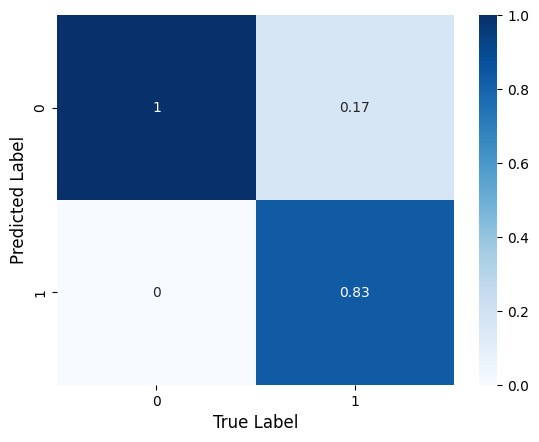

In [107]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.81

In [108]:
predicted_val_logi = logi.predict_proba(test)[:, 1]
winner_lg = pd.concat([BB_Hindi_participants, pd.DataFrame(predicted_val_logi, columns=['Predicted_Winner'])], axis=1)
winner_lg.sort_values('Predicted_Winner', ascending=False).style.hide()

Name,Predicted_Winner
Abhishek Kumar,0.080006
Munawar Faruqui,0.000033
Vikki Jain,0.000012
Mannara Chopra,0.000011
Ankita Lokhande,0.000002
Arun Srikanth Mahashetty,0.000000


## 💥 Predicted Winner for Bigg Boss Hindi Season 17, as per Logistic Regression

In [109]:
# Predicted Winner for Bigg Boss Hindi 17 Season, as per LogisticRegression
winner_lg[winner_lg['Predicted_Winner'] == np.amax(winner_lg.Predicted_Winner)].style.hide()

Name,Predicted_Winner
Abhishek Kumar,0.080006


In [110]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=2024).fit(x_train, y_train)
rf

RandomForestClassifier(n_estimators=200, random_state=2024)

In [111]:
predicted_val_rf = rf.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_rf > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

# n_estimators=200 accuracy 97.33

F1 Score - 99.60891297838056
Accuracy Score - 99.61685823754789


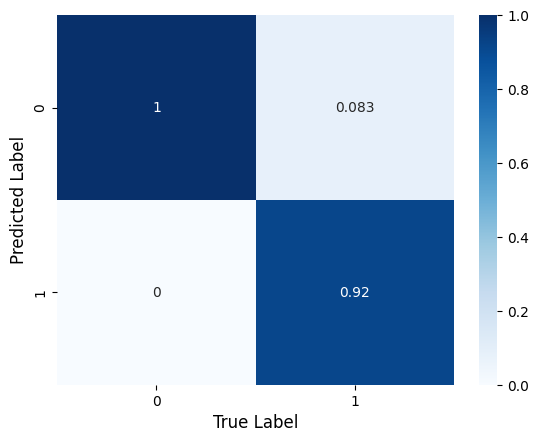

In [112]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.75

In [113]:
predicted_val_rf = rf.predict_proba(test)[:, 1]
winner_rf = pd.concat([BB_Hindi_participants, pd.DataFrame(predicted_val_rf, columns=['Predicted_Winner'])], axis=1)
winner_rf.sort_values('Predicted_Winner', ascending=False).style.hide()

Name,Predicted_Winner
Abhishek Kumar,0.180000
Munawar Faruqui,0.080000
Ankita Lokhande,0.030000
Mannara Chopra,0.030000
Vikki Jain,0.005000
Arun Srikanth Mahashetty,0.000000


## 💥 Predicted Winner for Bigg Boss Hindi Season 17, as per Random Forest

In [114]:
# Predicted Winner for BiggBoss Hindi 17 Season, as per RandomForest
winner_rf[winner_rf['Predicted_Winner'] == np.amax(winner_rf.Predicted_Winner)].style.hide()

Name,Predicted_Winner
Abhishek Kumar,0.180000


## 🚀 Machine Learning (ML) models to predict Indian BiggBoss (Big Brother) season Winners

## Kannada Bigg Boss Season10
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-kannada-season-10-winner

## Telugu Bigg Boss Season7
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-telugu-season-7-winner

## Tamil Bigg Boss Season7
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-tamil-season-7-winner

## Malayalam Bigg Boss Season5
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-malayalam-season-5-winner

## Marathi Bigg Boss Season5
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-marathi-season-5-winner

## Bangla Bigg Boss Season3
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-bangla-season-3-winner

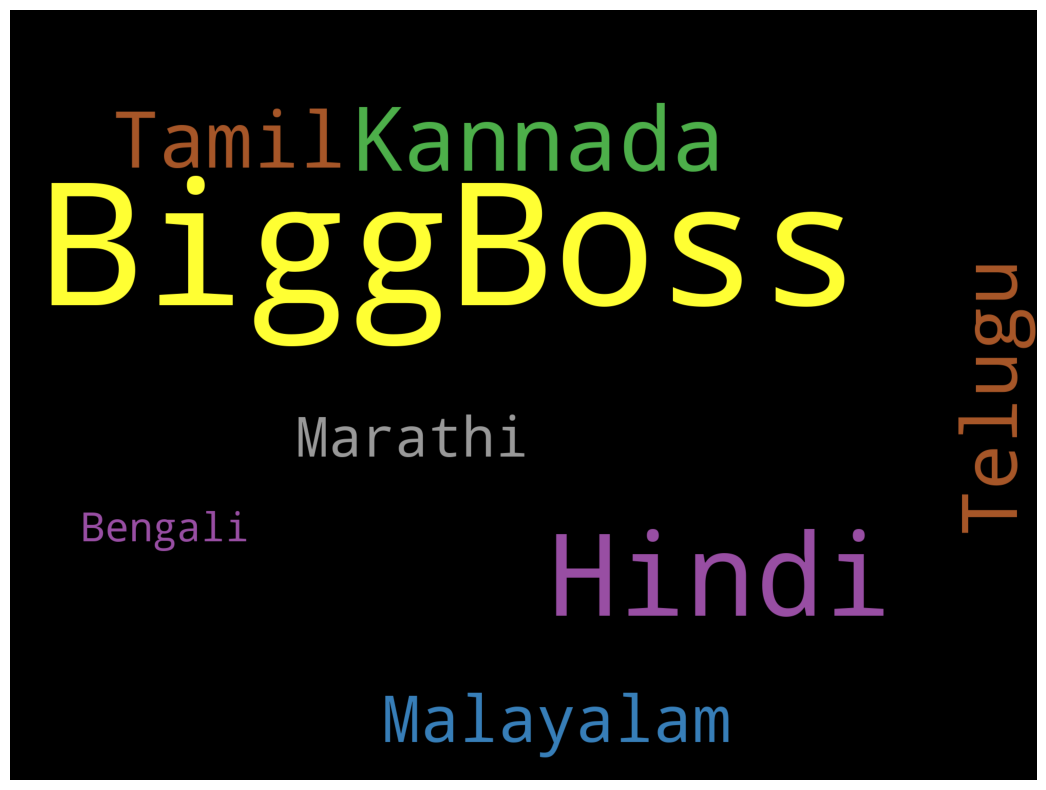

In [115]:
# Word cloud of Bigg Boss Languages
text = " BiggBoss ".join(cat for cat in bigg_boss['Language'])
wordcloud = WordCloud(width=2000, height=1500, background_color='Black', colormap='Set1', collocations=False, random_state=2024).generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

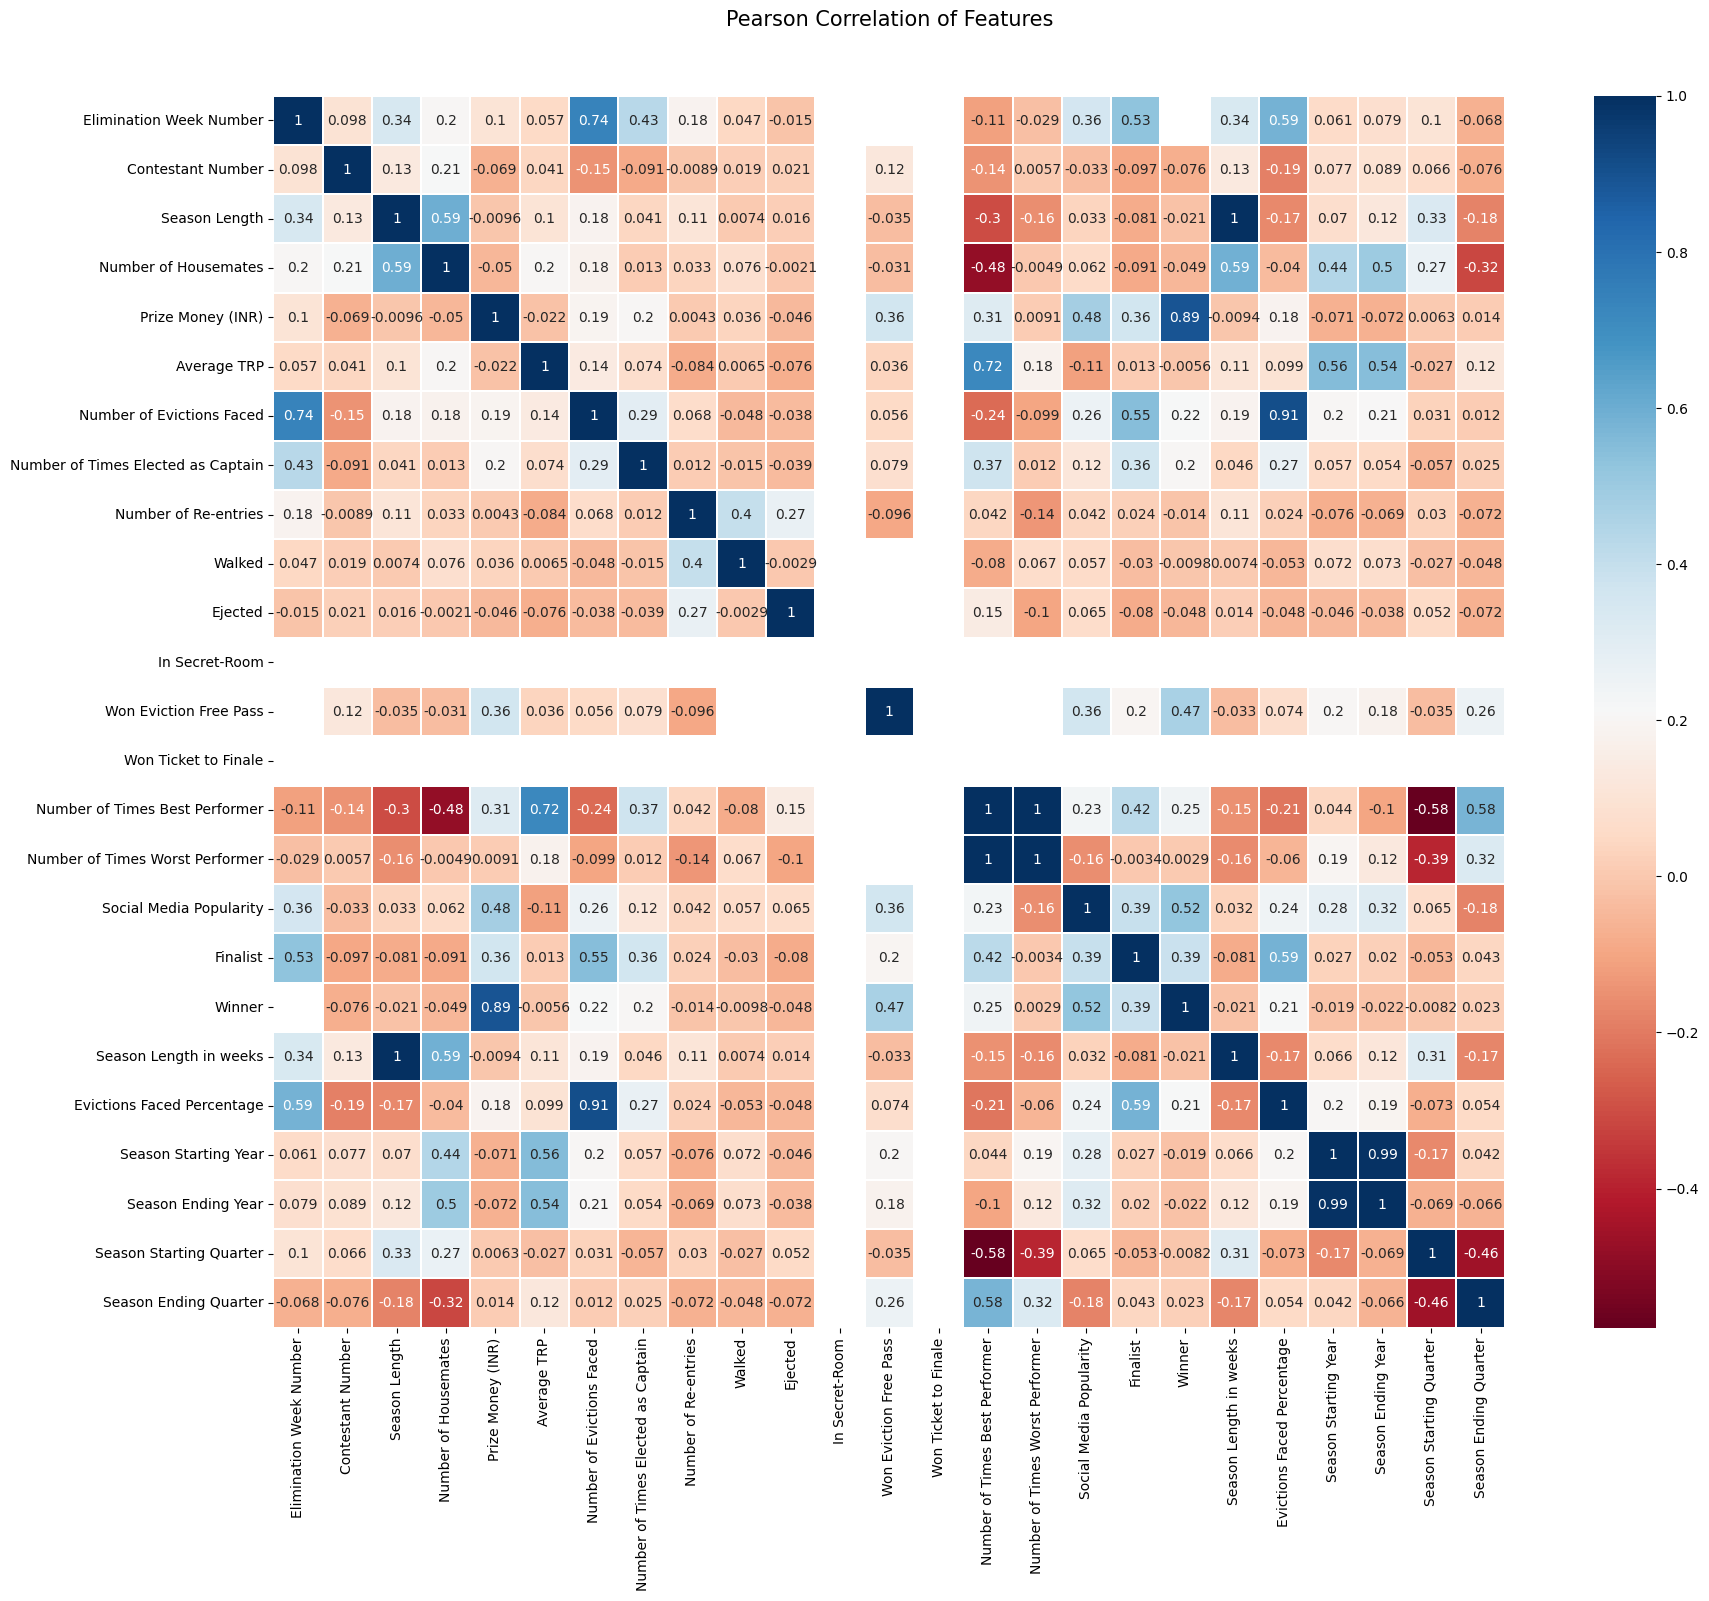

In [116]:
# Correlation matrix (Heatmap style)
corrmat = bigg_boss.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(23, 16))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corrmat, vmax=1.0, linewidths=0.1, square=True, cmap="RdBu", linecolor='white', annot=True);

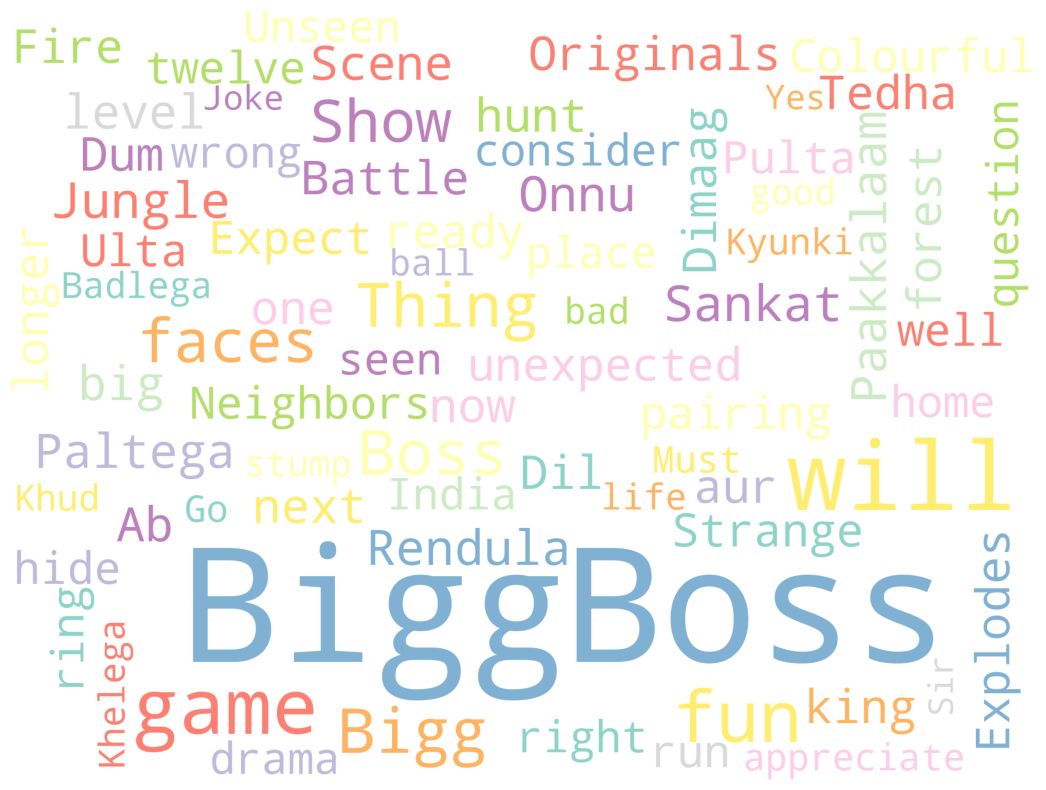

In [117]:
# Word cloud of Bigg Boss Season Slogans
text = " BiggBoss ".join(str(cat) for cat in bigg_boss[bigg_boss['Season Slogan'].notnull()]['Season Slogan'])
wordcloud = WordCloud(width=2000, height=1500, background_color='white', colormap='Set3', collocations=False, random_state=2024).generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [118]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
import matplotlib
print("matplotlib version: {}". format(matplotlib. __version__))
print("seaborn version: {}". format(sns.__version__))
import sklearn
print("sklearn version: {}". format(sklearn.__version__))
import plotly
print("plotly version: {}". format(plotly.__version__))

# Current Python package versions
# numpy version: 1.24.3
# pandas version: 2.0.3
# matplotlib version: 3.7.4
# seaborn version: 0.12.2
# sklearn version: 1.2.2
# plotly version: 5.16.1

numpy version: 1.24.3
pandas version: 2.0.3
matplotlib version: 3.7.4
seaborn version: 0.12.2
sklearn version: 1.2.2
plotly version: 5.16.1
